# LIM forecasting: Train on model data - validate out sample model

Katie Brennan  
started May 2021  
  
#### Goals: 
* Build LIM with all months 
* Train on: combination of historical and LM simulations
* Validate on: different model output, satellite data, historical simulations

In [8]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy
import pickle 

import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

import time as timestamp 

In [9]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils as lim

import LIM_utils_kb as limkb
import LIM_stats_kb as statskb
import LIM_plot_kb as plotkb
import LIM_building as limbuild

In [10]:
import importlib
importlib.reload(limkb)
importlib.reload(statskb)
importlib.reload(limbuild)

<module 'LIM_building' from '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_building.py'>

In [11]:
# %load_ext autoreload
# %autoreload 2

In [12]:
arc_proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                              central_longitude=-45,
                                              true_scale_latitude=0.1))
proj = dict(projection=ccrs.Robinson(central_longitude=0.),zorder=1)

In [13]:
month_names = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

In [65]:
15*12

180

In [89]:
# number of EOFs to retain for the LIM state vector
ntrunc = 30 # EOF truncation for individual fields (reduced-state space)
nmodes = 30 # number of coupled EOFs for LIM state space (truncated-state space)
# ntrunc = 50
# nmodes = 50
#nmodes = 25
nmodes_sic = 50
#modes_sic = 20

mo='all'
#mo=0

# forecast lead time in months that defines the LIM training
tau = 1

# training data defined by the first ntrain times
# fraction of years used in training
# ensures that start year of both train and validation data is january 
ntrain = 1

#nvalidtimes = 1872, 
#nvalidtimes = 3600
nvalidtimes = 180

ntraintimes = 1872-nvalidtimes

#nttrain_valid = 1
#ntrain_valid = 0.3
ntrain_valid = nvalidtimes/1872

# variables to include in the LIM (note "vars" is a Python command)
#limvars = ['tas','zg']
#limvars = ['tas','rlut','zg']
# limvars = ['sic']
#limvars = ['tas','sic']
#limvars = ['tas','sic','zg','psl','pr','tos']
#limvars = ['tas','psl','tos','sit','sic']
# limvars = ['tas','tos','psl','sit','sic']
# limvars_nosic = ['tas','tos','psl','sit']
#limvars = ['tas','tos','psl','sit','sic']
limvars = ['tas','tos','psl','sit','sic']
limvars_nosic = ['tas','tos','psl','sit']
#limvars_nosic = []
nvars = len(limvars)

# specify the model source 
train_dsource = 'mpi_hist_kb'
#train_dsource = 'cmip6_mpi_hist'
#train_dsource = 'mpi_lm_kb'

valid_dsource = 'mpi_hist_kb'
#valid_dsource = 'mpi_lm_kb'
#valid_dsource = 'cmip6_mpi_hist'

sic_separate = True
#sic_separate = False
Insamp = False

In [67]:
from datetime import date

today = date.today()

#Year-month-day
today_date = today.strftime("%Y%m%d")

In [68]:
import warnings
warnings.filterwarnings("ignore")

In [69]:
pi = np.pi

# fill continents if plotting SST; otherwise no
# if var_to_extract == 'tos':
#     noland = True
# else:
#     noland = False

infile_20cr_tas = '/home/disk/kalman3/rtardif/LMR/data/model/20cr/tas_sfc_Amon_20CR_185101-201112.nc'

fdic_train = limkb.build_training_dic(train_dsource)
fdic_valid = limkb.build_training_dic(valid_dsource)

full_names, areawt_name, month_names = limbuild.load_full_names()
areacell, areacell_dict = limbuild.load_areacell_dict(fdic_train, remove_climo=False, 
                                                      detrend=False, verbose=False )

Loading from nts/SeaIceData/MPI/areacella_fx_MPI-ESM-P_past1000_r0i0p0.nc
Loading from nts/SeaIceData/MPI/areacello_fx_MPI-ESM-P_past1000_r0i0p0.nc


In [70]:
# wt=True
# var_dict = {}


# for k, var in enumerate(['tas']): 
#     X_var, var_dict = limkb.load_data(var, var_dict, fdic_train, remove_climo=True, 
#                                       detrend=True, verbose=True)
    
#     #x_var = X_var[70*12:110*12,:,:]
    
#     tsamp = X_var.shape[1]
    
#     acell = areacell[areawt_name[var]]
#     if len(acell.shape)>1:
#         acell_1d = np.reshape(acell,(acell.shape[0]*acell.shape[1]))
#     else: 
#         acell_1d = acell
     
#     [Ptrunc, E3, tot_var,
#      tot_var_eig, W_all, 
#      standard_factor, vexp] = limkb.step1_compress_individual_var(X_var, var, ntrunc, nmodes_sic, 
#                                                             var_dict, areawt=acell_1d,
#                                                             wt=wt, sic_separate=False)

In [71]:
# var = 'tas'
# var_dict = {}

# X_var, var_dict = limkb.load_data(var, var_dict, fdic_train, remove_climo=True, 
#                                   detrend=True, verbose=True)

In [13]:
# tsamp = X_var.shape[1]
    
# acell = areacell[areawt_name[var]]
# if len(acell.shape)>1:
#     acell_1d = np.reshape(acell,(acell.shape[0]*acell.shape[1]))
# else: 
#     acell_1d = acell

In [14]:
# trunc = ntrunc
# areawt=acell_1d
# wt=True

# if len(var_dict[var]['lat'].shape)<2:
#     nlon = var_dict[var]['lon'].shape[0]
#     nlat = var_dict[var]['lat'].shape[0]
#     lat = var_dict[var]['lat'][:,np.newaxis]*np.ones((nlat,nlon))
# else: 
#     lat = var_dict[var]['lat']

In [15]:
# [eofs_out, svals_out, pcs_out, 
#  tot_var, tot_var_eig, 
#  var_expl_by_retained, W] = limkb.eof_decomp_1var(X_var,lat,var_dict[var]['var_ndof'],
#                                                 X_var.shape[1],trunc,areawt=areawt,Weight=wt)
# W_all = np.squeeze(W)

# # Projection
# P_var = np.matmul(eofs_out.T,W*np.nan_to_num(X_var))

In [16]:
# print('fraction in first '+str(ntrunc)+ ' '+var+' EOFs = '+str(var_expl_by_retained))

In [17]:
# ntime = X_var.shape[1]
# standard_factor1 = np.sqrt((np.sum(np.var(P_var,axis=1))))
# standard_factor2 = (np.sum(np.var(P_var,axis=1)))
# standard_factor3 = np.sqrt(np.sum(svals_out*svals_out))/(ntime-1)
# Ptrunc1 = P_var/standard_factor1
# Ptrunc2 = P_var/standard_factor2
# Ptrunc3 = P_var/standard_factor3

## Build L from scratch: 

### Load pre-truncated training data: 

In [72]:
## Start with full training data: 
# [Ptrunc, Ptrunc_valid, E3, tot_var, 
#  tot_var_eig, W_all,standard_factor, nyears_train, 
#  var_dict] = limbuild.load_training_valid_data_full(limvars, fdic_train, mo, areacell, ntrain, 
#                                                     areawt_name, ntrunc, nmodes_sic, 
#                                                     sic_separate=sic_separate,
#                                                     remove_climo=True,detrend=True, 
#                                                     wt=True, verbose=True)

#limvars = ['tas', 'tos','sit','sic']
#limvars = ['sic']

# Start with truncated training data: 
#mod_folder = 'truncated_model_data/last_millennium/'
mod_folder = 'truncated_model_data/'
#mod_filename = '_ntrunc30_mpi_lm_kb_20210503.pkl'
#mod_filename = '_ntrunc30_monthall_ccsm4_hist_kb_20210507_ntrain1_standtest.pkl'
#mod_filename = '_ntrunc30_monthall_mpi_hist_kb_20210507_ntrain1_standtest.pkl'
#mod_filename = '_ntrunc30_mpi_lm_kb_20210507_ntrain0_3_standtest.pkl'
mod_filename = '_ntrunc'+str(ntrunc)+'_monthall_mpi_hist_kb_20210824_ntrain_1850_1999_standtest.pkl'

#mod_sic_filename = '_ntrunc50_mpi_lm_kb_20210406.pkl'
#mod_sic_filename = '_ntrunc50_monthall_ccsm4_hist_kb_20210507_ntrain1_standtest.pkl'
#mod_sic_filename = '_ntrunc50_monthall_mpi_hist_kb_20210507_ntrain1_standtest.pkl'
#mod_sic_filename = '_ntrunc50_month0_mpi_hist_kb_20210727_ntrain1_standtest.pkl'
#mod_sic_filename = '_ntrunc50_mpi_lm_kb_20210507_ntrain0_3_standtest.pkl'
mod_sic_filename = '_ntrunc'+str(nmodes_sic)+'_monthall_mpi_hist_kb_20210824_ntrain_1850_1999_standtest.pkl'

[Ptrunc, _, E3, tot_var, 
 tot_var_eig, W_all, standard_factor, 
 nyears_train, var_dict] = limbuild.load_training_data_truncated(limvars, mod_folder, mod_sic_filename, 
                                                                 mod_filename, mo,1,ind_month_trunc=True)

var_dict = limbuild.get_var_indices(limvars, var_dict)

Loading truncated tas
Loading truncated tos
Loading truncated psl
Loading truncated sit
Loading truncated sic
working on tas
working on tos
working on psl
working on sit
working on sic


In [19]:
W_all['tas'].shape, W_all['tos'].shape, W_all['sic'].shape

((18432,), (56320,), (56320,))

In [20]:
 np.sum(np.var(Ptrunc['sic'],axis=1)),np.sum(np.var(Ptrunc['tas'],axis=1)), #np.sum(np.var(Ptrunc['sit'],axis=1))

(1.0, 1.0000000000000002)

In [21]:
var = 'sic'
if var == 'sic': 
    mod_fname = mod_sic_filename
else: 
    mod_fname = mod_filename

[X_var, v, E3[var], standard_factor[var], 
 W_all[var]] = limkb.load_truncated_data(var, mod_folder, mod_fname)

Loading truncated sic


In [ ]:
# ntime = X_var.shape[1]
# nyears_train = int((ntime*ntrain)/12)
# nyears_valid = int((ntime*(1-ntrain))/12)

# X_t = np.reshape(X_var,(X_var.shape[0],int(ntime/12),12))

# X_train = X_t[:,0:nyears_train,mo:mo+2]
# X_train_2d = np.reshape(X_train,(X_train.shape[0],nyears_train*2))
# X_valid = X_t[:,nyears_train:,mo]

In [ ]:
nyears_valid, nyears_train, X_t.shape, X_train.shape, X_train_2d.shape, X_valid.shape

In [ ]:
# plt.plot(Ptrunc['tas'][0,:])
# plt.plot(Ptrunc['tos'][0,:])
plt.plot(Ptrunc['sic'][0,:])

In [73]:
ndof_all = limkb.count_ndof_all(limvars, E3, sic_separate=sic_separate)

[Ptrunc_all, E3_all, 
Ptrunc_sic,E_sic] = limkb.stack_variable_eofs(limvars, ndof_all, ntrunc, Ptrunc, E3, 
                                              var_dict, sic_separate=sic_separate)

P_train = np.concatenate((Ptrunc_all, Ptrunc_sic),axis=0)


# [P_train, Fvar, E] = limkb.step2_multivariate_compress(Ptrunc_all, nmodes, E3_all, Ptrunc_sic, 
#                                                        sic_separate=sic_separate, Trunc_truth=False)

# [Ptrunc_all, E3_all] = limkb.stack_variable_eofs(limvars, ndof_all, ntrunc, Ptrunc, E3, 
#                                                  var_dict, sic_separate=sic_separate)

# [P_train, Fvar, E] = limkb.step2_multivariate_compress(Ptrunc_all,nmodes, E3_all, 0, 
#                                                        sic_separate=sic_separate, Trunc_truth=False)

0, tas
1, tos
2, psl
3, sit


In [23]:
# P_train = Ptrunc['sic']
# nmo = int(P_train.shape[1]/nyears_train)
# nmo, nyears_train

## Train LIM: 

In [74]:
nmo = int(P_train.shape[1]/nyears_train)
# nmo = 2
P_train_3d = np.reshape(P_train, (P_train.shape[0],nyears_train,nmo))

if mo is 'all':
    LIMd2, G2 = lim.LIM_train(tau,P_train)
    print('Training LIM with tau = '+str(tau))
else: 
    LIMd2, G2 = lim.LIM_train_flex(tau,P_train_3d[:,:,0], P_train_3d[:,:,1])
    print('Training LIM with tau = '+str(tau))

Training LIM with tau = 1


In [75]:
max_eigenval = np.real(LIMd2['lam_L']).max()

if max_eigenval >0: 
    LIMd2['lam_L_adj'] = LIMd2['lam_L'] - (max_eigenval+0.01)
else: 
    LIMd2['lam_L_adj'] = LIMd2['lam_L']

#### Any positive eigenvalues in L?

In [76]:
(LIMd2['lam_L']>0).sum()/(LIMd2['lam_L'].shape[0])

0.0

## Load and project validation data (when different than training data): 

In [88]:
1872-15*12

1692

In [91]:
Ptrunc_valid = {}
var_dict_valid = {}

for k, var in enumerate(limvars): 
    print('Validation data: '+valid_dsource)
    X_var, var_dict_valid = limkb.load_data(var, var_dict_valid, fdic_valid, remove_climo=True, 
                                            detrend=True, verbose=True)
        
    Ptrunc_valid[var] = limkb.step1_projection_validation_var(X_var[:,ntraintimes:], E3[var], 
                                                              standard_factor[var],W_all[var])

Validation data: mpi_hist_kb
Loading from tas
Loading from ta/MPI/tas_Amon_MPI-ESM-P_historical_r1i1p1_185001-200512.nc
removing climotology...
detrending...
(18432, 1872)
(18432, 1872)
-----------------------------------------------------
completed in 2.7912988662719727 seconds
-----------------------------------------------------
Validation data: mpi_hist_kb
Loading from tos
Loading from ta/MPI/tos_Omon_MPI-ESM-P_historical_r1i1p1_185001-200512.nc
removing climotology...
detrending...
(56320, 1872)
(56320, 1872)
-----------------------------------------------------
completed in 7.4804301261901855 seconds
-----------------------------------------------------
Validation data: mpi_hist_kb
Loading from psl
Loading from ta/MPI/psl_Amon_MPI-ESM-P_historical_r1i1p1_185001-200512.nc
removing climotology...
detrending...
(18432, 1872)
(18432, 1872)
-----------------------------------------------------
completed in 2.8313791751861572 seconds
----------------------------------------------------

In [92]:
var_dict_valid = limbuild.get_var_indices(limvars, var_dict_valid)
ndof_all_valid = limkb.count_ndof_all(limvars, E3, sic_separate=sic_separate)

[Ptrunc_all_valid, E3_all_valid,
 Ptrunc_sic_valid, E_sic_valid] = limkb.stack_variable_eofs(limvars, ndof_all_valid, ntrunc, Ptrunc_valid,
                                                            E3, var_dict_valid, sic_separate=sic_separate)
# [Ptrunc_all_valid, E3_all_valid] = limkb.stack_variable_eofs(limvars, ndof_all_valid, ntrunc, Ptrunc_valid,
#                                                             E3, var_dict_valid, sic_separate=sic_separate)

P_train_valid = np.concatenate((Ptrunc_all_valid, Ptrunc_sic_valid),axis=0)
P_train_valid.shape

# [P_train_valid, Fvar_valid, 
#  E_valid] = limkb.step2_multivariate_compress(Ptrunc_all_valid,nmodes, E3_all_valid, Ptrunc_sic_valid,
#                                               sic_separate=sic_separate, Trunc_truth=False)

working on tas
working on tos
working on psl
working on sit
working on sic
0, tas
1, tos
2, psl
3, sit


(170, 180)

In [33]:
sic_decomp = np.matmul(E3['sic'],Ptrunc_valid['sic'])
sic_dcomp = limkb.unweight_decompressed_vars(sic_decomp, ['sic'], var_dict, W_all)

#### Checks: 

In [ ]:
var_dict_test ={}
X_var,_ = limkb.load_data('sic', var_dict_test, fdic_valid, remove_climo=True, 
                           detrend=True, verbose=True)

In [ ]:
i = 1070
plt.plot(X_var[i,:], label='original')
plt.plot(sic_dcomp[i,:], label='decomp')
plt.title('SIC')
plt.legend()

In [ ]:
tas_decomp = np.matmul(E3['tas'],Ptrunc_valid['tas'])
tas_dcomp = limkb.unweight_decompressed_vars(tas_decomp, ['tas'], var_dict, W_all)

In [ ]:
var_dict_test ={}
X_var,_ = limkb.load_data('tas', var_dict_test, fdic_valid, remove_climo=True, 
                           detrend=True, verbose=True)

In [ ]:
i = 1070
plt.plot(X_var[i,:], label='original')
plt.plot(tas_dcomp[i,:], label='decomp')
plt.title('TAS')
plt.legend()

In [ ]:
np.sum(np.var(P_train_valid[0:30,:],axis=1)), np.sum(np.var(P_train_valid[30:60,:],axis=1)), np.sum(np.var(P_train_valid[60:,:],axis=1))

In [ ]:
plt.plot(P_train_valid[0,:])
plt.plot(P_train_valid[30,:])
plt.plot(P_train_valid[60,:])

In [87]:
P_train_valid.shape

(170, 72)

## Run Forecast: 

In [31]:
#nvalidtimes = 1872, 
#nvalidtimes = 3600

In [93]:
# LIM forecasts for a range of monthly values (can specify a list of arbitrary values too)
lags = [0,1,2,3,4]
#lags = [0,1,2]
ntims = len(lags)
adj = True

nyr_train = nyears_train

if mo == 'all':
    print('Using all months')
    if Insamp==True: 
        print('Performing in sample forecast')
        LIM_fcast = limkb.LIM_forecast(LIMd2,P_train[:,0:nyr_train],lags,adjust=adj)
    else: 
        print('Performing out of sample forecast')
        LIM_fcast = limkb.LIM_forecast(LIMd2,P_train_valid[:,0:nvalidtimes],lags,adjust=adj)
#        LIM_fcast = limkb.LIM_forecast(LIMd2,P_train_valid[:,0:nvalidtimes],lags,adjust=adj)
#        LIM_fcast = limkb.LIM_forecast(LIMd2,P_train_valid[:,70*12:111*12],lags,adjust=adj)
else: 
    print('Using individual months')
    if Insamp==True: 
        print('Performing in sample forecast')
        P_train_2d = np.reshape(P_train, (P_train.shape[0],int(P_train.shape[1]/2),2))
        LIM_fcast = limkb.LIM_forecast(LIMd2,P_train_2d[:,:,0],lags,adjust=adj)
    else: 
        print('Performing out of sample forecast')
#        LIM_fcast = limkb.LIM_forecast(LIMd2,P_train_valid,lags,adjust=adj)
        LIM_fcast = limkb.LIM_forecast(LIMd2,P_train_valid,lags,adjust=adj)
    
#LIM_fcast = LIM_forecast_Gt(LIMd2,P_train_valid,lags)

Using all months
Performing out of sample forecast
Adjust is True...
NO negative eigenvalue found...
t= 0
t= 1
t= 2
t= 3
t= 4


In [36]:
LIMd2['lam']

KeyError: 'lam'

In [ ]:
t=0
Gt = np.matmul(np.matmul(LIMd2['vec'],np.diag(np.exp(LIMd2['lam_L_adj']*t))),LIMd2['veci'])
LIMd2['vec'].shape

In [ ]:
LIM_fcast['x_forecast'].shape[2],E3_all.shape[0]+E_sic.shape[0],len(lags)

## Decompress forecast and validate:

In [94]:
x_forecast_dcomp = np.zeros((len(lags),E3_all.shape[0]+E_sic.shape[0],LIM_fcast['x_forecast'].shape[2]))
nmodes = E3_all.shape[1]

for i,lag in enumerate(lags):
    print('Lag '+ str(lag))
    x_forecast_dcomp[i,:,:] = limkb.decompress_eof_separate_sic(LIM_fcast['x_forecast'][i,:,:],
                                                                nmodes,nmodes_sic,E3_all,
                                                                E_sic,limvars,var_dict,
                                                                W_all,Weights=True,
                                                                sic_separate=sic_separate)

Lag 0
Lag 1
Lag 2
Lag 3
Lag 4


In [ ]:
x_forecast_dcomp.shape, LIM_fcast['x_forecast'].shape, var_dict['tas']['lat'].shape,var_dict['tas']['lon'].shape

## AR(1) Forecast: 

In [95]:
nyearsvalid = 15

In [96]:
forecast, ar1_factor = statskb.red_noise_forecast_ar1(P_train.T, P_train_valid.T, lead=1)

In [97]:
nmodes = E3_all.shape[1]
ar1_forecast_dcomp = np.zeros((E3_all.shape[0]+ E_sic.shape[0],nyearsvalid*12))

ar1_forecast_dcomp[:,1:] = limkb.decompress_eof_separate_sic(forecast.T,nmodes,nmodes_sic,E3_all,
                                                             E_sic,limvars,var_dict,W_all,Weights=True,
                                                             sic_separate=sic_separate)

forecast_ar1_mo = np.reshape(ar1_forecast_dcomp, (ar1_forecast_dcomp.shape[0],nyearsvalid,12))

Loading from tas
Loading from ta/MPI/tas_Amon_MPI-ESM-P_historical_r1i1p1_185001-200512.nc
removing climotology...
detrending...
(18432, 1872)
(18432, 1872)
-----------------------------------------------------
completed in 2.8325002193450928 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


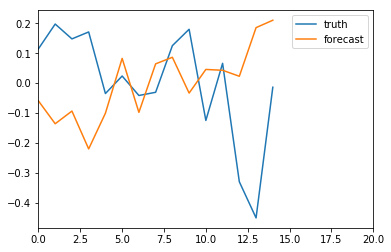

Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


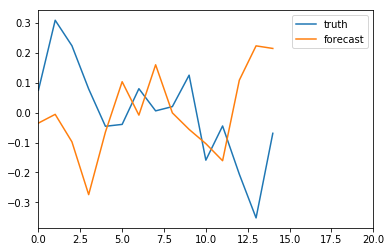

Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


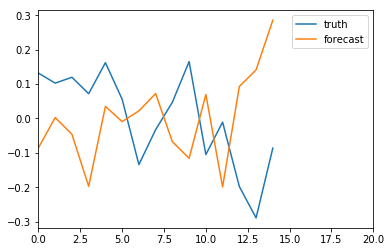

Month 3
Trained using month 3...
Validating against month 3
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


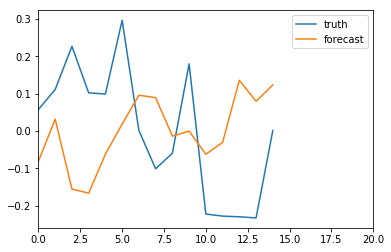

Month 4
Trained using month 4...
Validating against month 4
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


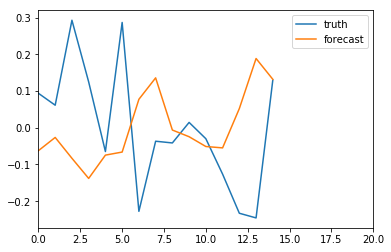

Month 5
Trained using month 5...
Validating against month 5
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


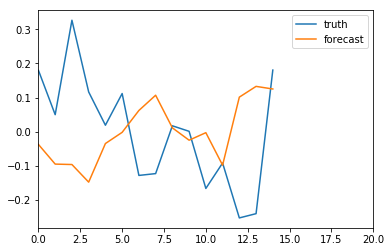

Month 6
Trained using month 6...
Validating against month 6
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


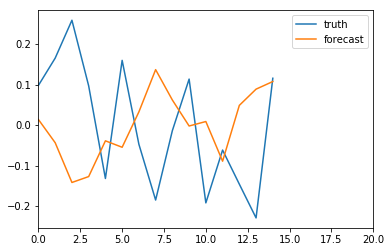

Month 7
Trained using month 7...
Validating against month 7
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


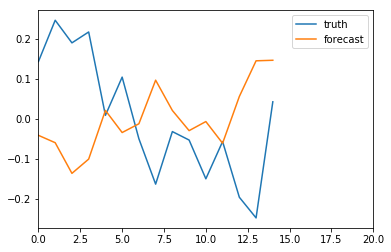

Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


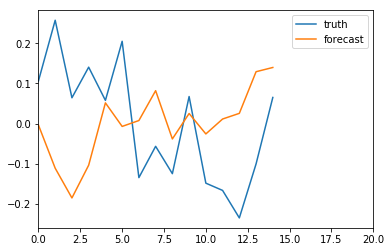

Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


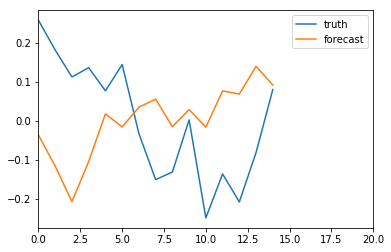

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


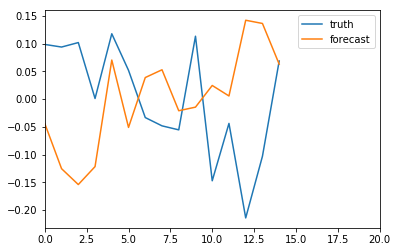

Loading from tos
Loading from ta/MPI/tos_Omon_MPI-ESM-P_historical_r1i1p1_185001-200512.nc
removing climotology...
detrending...
(56320, 1872)
(56320, 1872)
-----------------------------------------------------
completed in 7.721534252166748 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


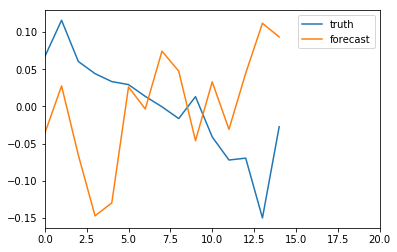

Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


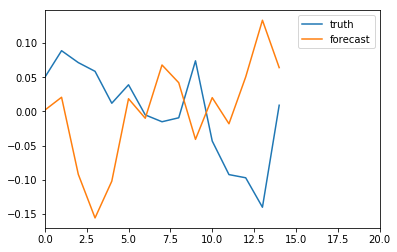

Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


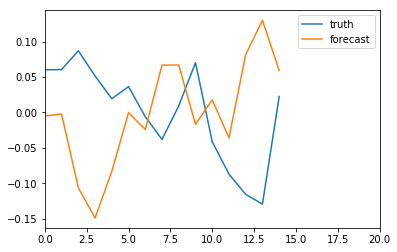

Month 3
Trained using month 3...
Validating against month 3
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


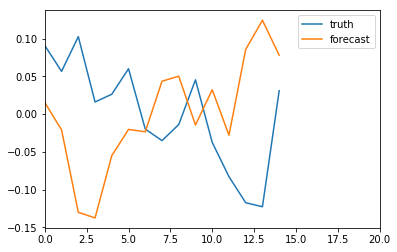

Month 4
Trained using month 4...
Validating against month 4
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


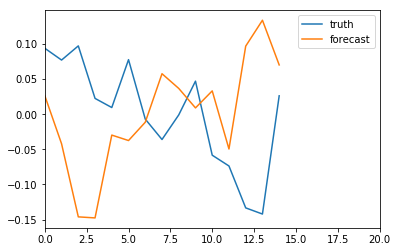

Month 5
Trained using month 5...
Validating against month 5
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


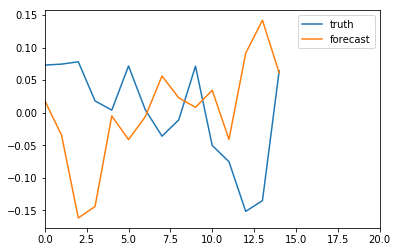

Month 6
Trained using month 6...
Validating against month 6
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


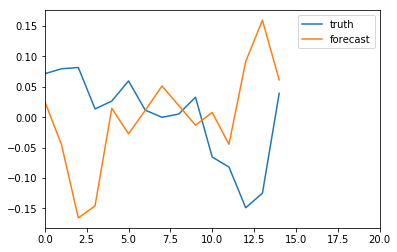

Month 7
Trained using month 7...
Validating against month 7
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


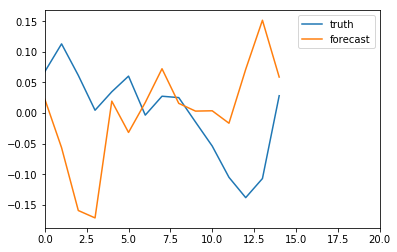

Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


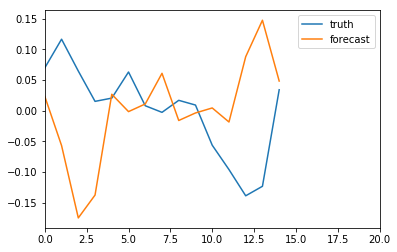

Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


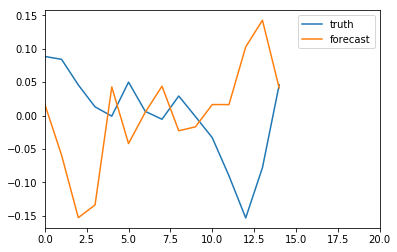

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


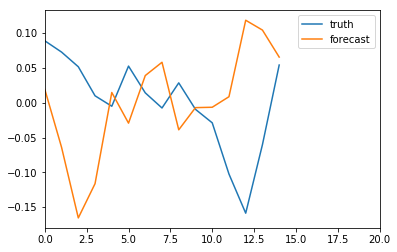

Loading from psl
Loading from ta/MPI/psl_Amon_MPI-ESM-P_historical_r1i1p1_185001-200512.nc
removing climotology...
detrending...
(18432, 1872)
(18432, 1872)
-----------------------------------------------------
completed in 2.7836923599243164 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


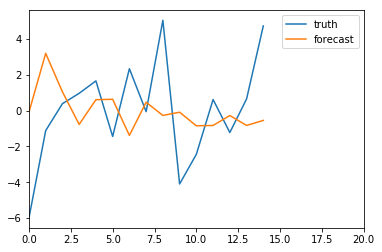

Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


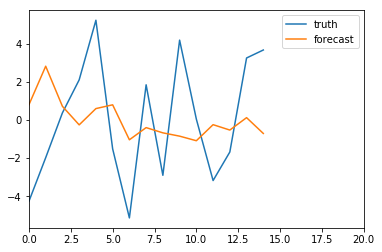

Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


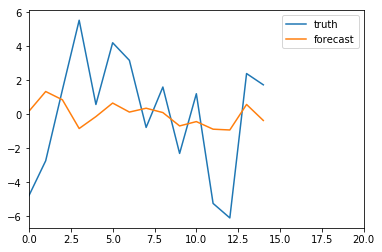

Month 3
Trained using month 3...
Validating against month 3
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


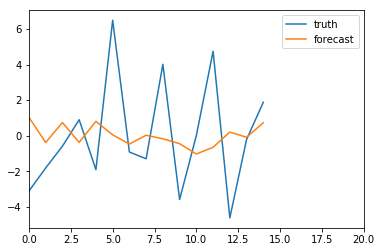

Month 4
Trained using month 4...
Validating against month 4
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


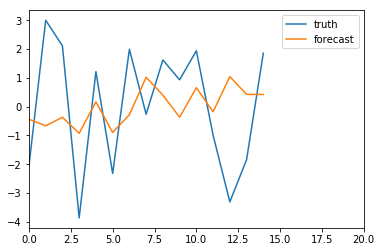

Month 5
Trained using month 5...
Validating against month 5
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


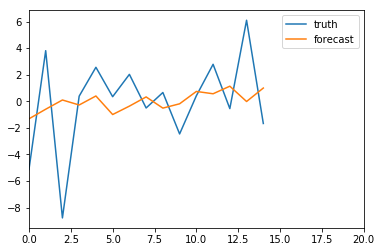

Month 6
Trained using month 6...
Validating against month 6
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


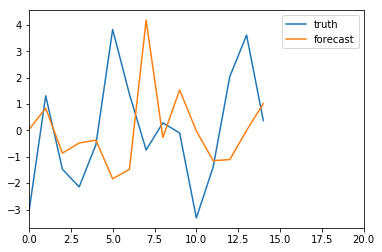

Month 7
Trained using month 7...
Validating against month 7
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


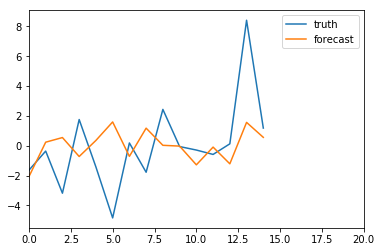

Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


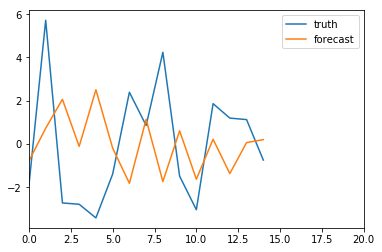

Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


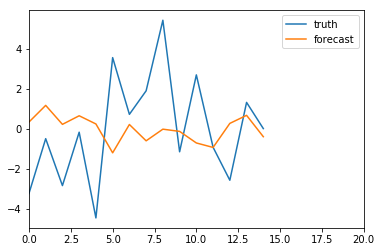

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


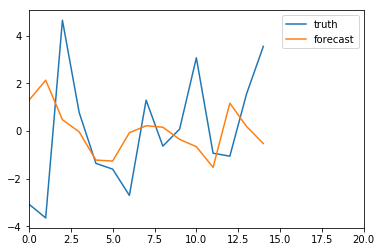

Loading from sit
Loading from a/MPI/sit_OImon_MPI-ESM-P_historical_r1i1p1_185001-200512.nc
removing climotology...
detrending...
(56320, 1872)
(56320, 1872)
-----------------------------------------------------
completed in 7.506350040435791 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


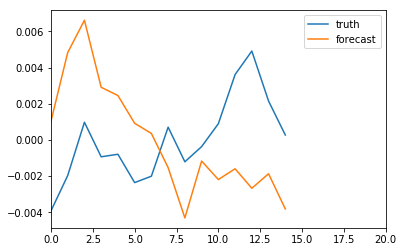

Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


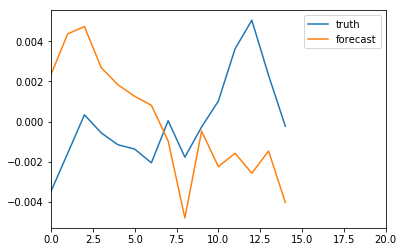

Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


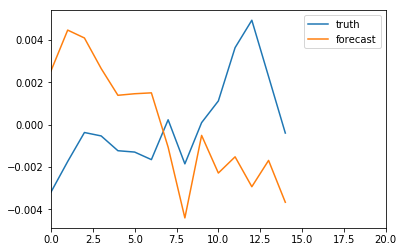

Month 3
Trained using month 3...
Validating against month 3
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


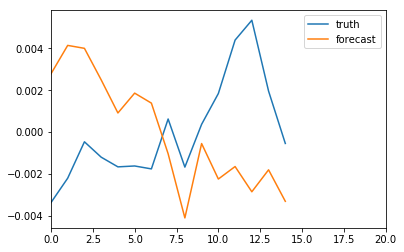

Month 4
Trained using month 4...
Validating against month 4
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


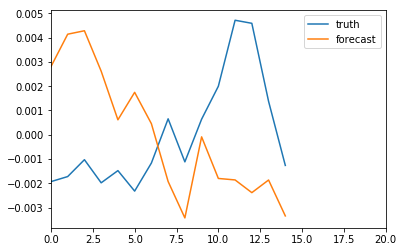

Month 5
Trained using month 5...
Validating against month 5
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


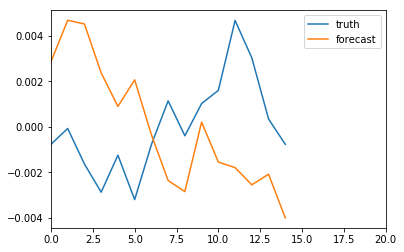

Month 6
Trained using month 6...
Validating against month 6
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


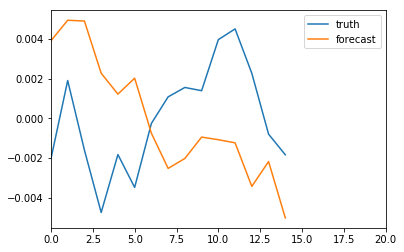

Month 7
Trained using month 7...
Validating against month 7
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


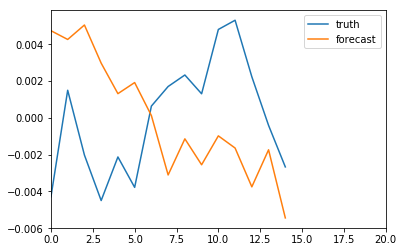

Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


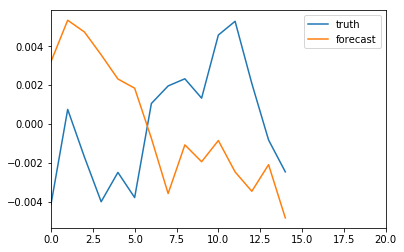

Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


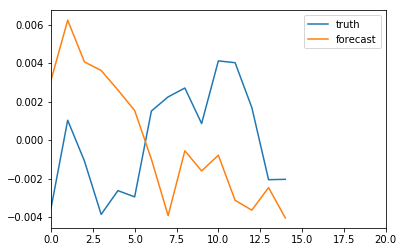

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


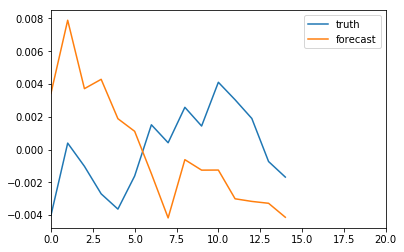

Loading from sic
Loading from a/MPI/sic_OImon_MPI-ESM-P_historical_r1i1p1_185001-200512.nc
removing climotology...
detrending...
(56320, 1872)
(56320, 1872)
-----------------------------------------------------
completed in 7.714314222335815 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


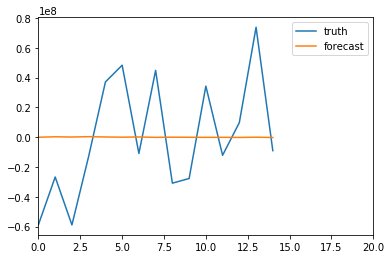

Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


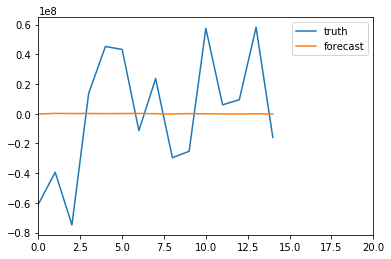

Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


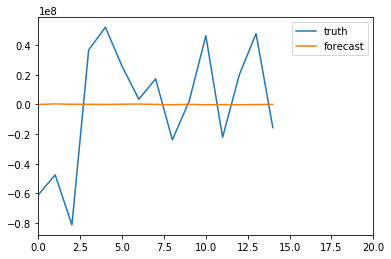

Month 3
Trained using month 3...
Validating against month 3
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


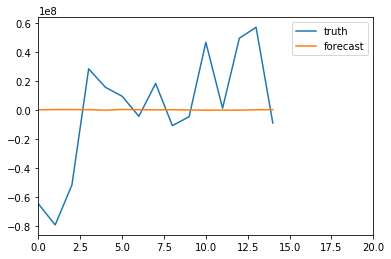

Month 4
Trained using month 4...
Validating against month 4
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


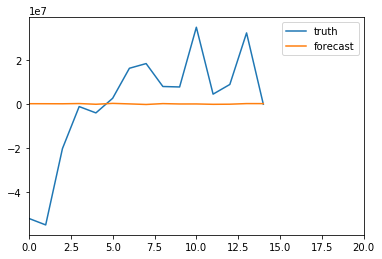

Month 5
Trained using month 5...
Validating against month 5
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


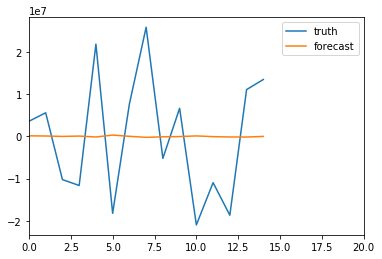

Month 6
Trained using month 6...
Validating against month 6
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


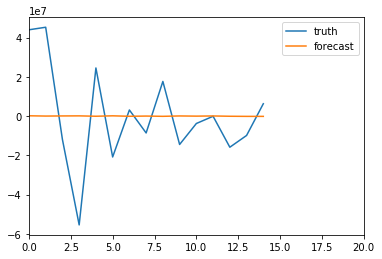

Month 7
Trained using month 7...
Validating against month 7
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


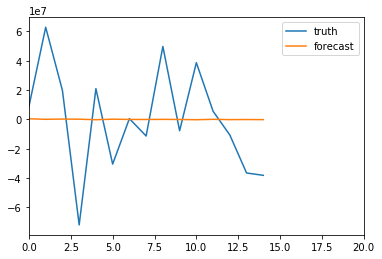

Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


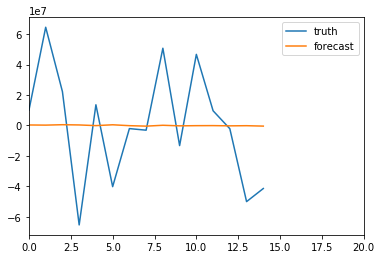

Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


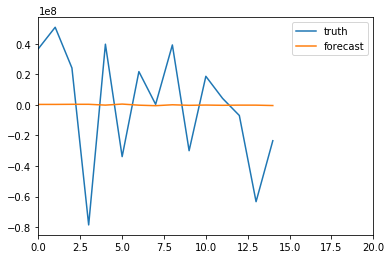

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


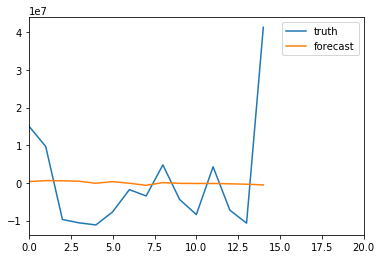

In [98]:
# validvars = ['tas','sic']
validvars = limvars
# validvars = ['psl']
months=[0,1,2,3,4,5,6,7,8,9,10]
lag=None
validation_stats_ar1 = {}
st=0

for k, var in enumerate(validvars):
    valid_stats_ar1 = {}
    v = {}
    X_var, _ = limkb.load_data(var, v, fdic_valid, remove_climo=True, detrend=True, verbose=True)
    
    corr_tot = np.zeros((len(months)))
    ce_tot = np.zeros((len(months)))
    gm_var_ratio = np.zeros((len(months)))
    
    for i,m in enumerate(months):
        print('Month '+str(m))
        
        [truth_anom, forecast_anom] = limbuild.gather_truth_forecast_allmo(lag,var,m,X_var[:,:nyearsvalid*12],
                                                                           forecast_ar1_mo[:,:,m],
                                                                           var_dict,ntrain_valid,0,insamp=False)
        st = st + var_dict[var]['var_ndof']
        
        print('Truth_anom shape: '+str(truth_anom.shape))
        print('Forecast_anom shape: '+str(forecast_anom.shape))

#         [corr_tot[i], ce_tot[i], gm_var_ratio[i], tot_var_forecast, 
#          tot_var_truth] = limbuild.calc_validataion_stats(var, truth_anom[:,70:111], forecast_anom, var_dict,
#                                                           areacell,areacell_dict,
#                                                           areawt_name,month_names,iplot=True)
        [corr_tot[i], ce_tot[i], gm_var_ratio[i], tot_var_forecast, 
         tot_var_truth] = limbuild.calc_validataion_stats(var, truth_anom, forecast_anom, var_dict,
                                                          areacell,areacell_dict,
                                                          areawt_name,month_names,iplot=True)
        
    valid_stats_ar1['corr_tot'] = corr_tot
    valid_stats_ar1['ce_tot'] = ce_tot
    valid_stats_ar1['gm_var_ratio'] = gm_var_ratio
    
    validation_stats_ar1[var] = valid_stats_ar1
    
    del X_var

### All months: break up my month

In [99]:
month_names = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov']

In [100]:
x_forecast_dcomp_mo = np.reshape(x_forecast_dcomp, (x_forecast_dcomp.shape[0], x_forecast_dcomp.shape[1], 
                                                    int(x_forecast_dcomp.shape[2]/12),12))

x_forecast_dcomp_mo.shape

(5, 205824, 15, 12)

Loading from tas
Loading from ta/MPI/tas_Amon_MPI-ESM-P_historical_r1i1p1_185001-200512.nc
removing climotology...
detrending...
(18432, 1872)
(18432, 1872)
-----------------------------------------------------
completed in 3.189028263092041 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


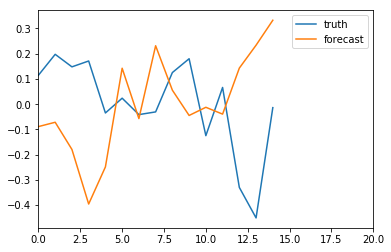

Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


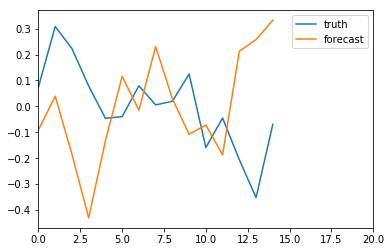

Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


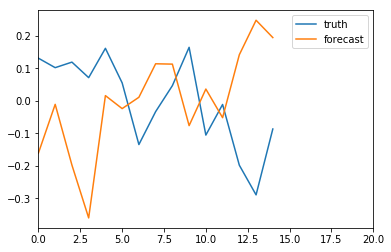

Month 3
Trained using month 3...
Validating against month 3
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


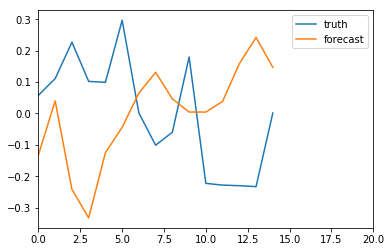

Month 4
Trained using month 4...
Validating against month 4
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


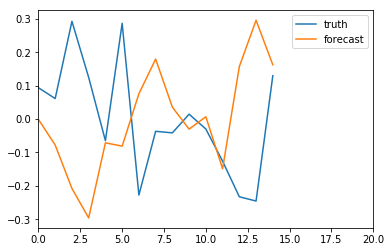

Month 5
Trained using month 5...
Validating against month 5
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


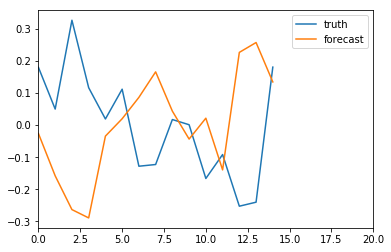

Month 6
Trained using month 6...
Validating against month 6
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


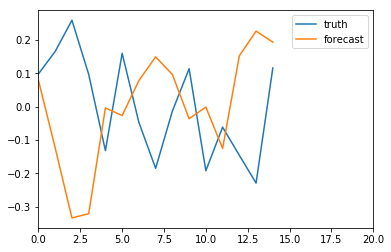

Month 7
Trained using month 7...
Validating against month 7
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


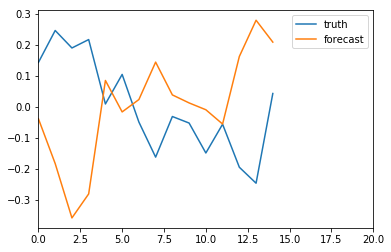

Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


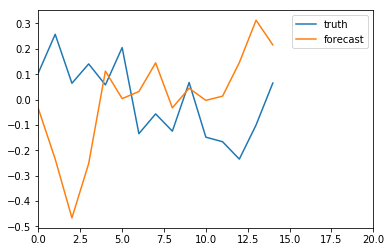

Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


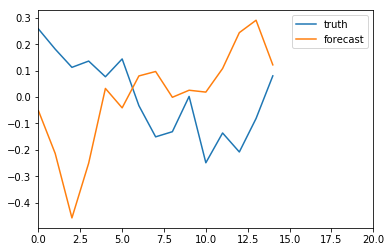

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


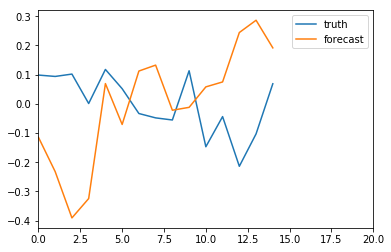

Loading from tos
Loading from ta/MPI/tos_Omon_MPI-ESM-P_historical_r1i1p1_185001-200512.nc
removing climotology...
detrending...
(56320, 1872)
(56320, 1872)
-----------------------------------------------------
completed in 7.627866983413696 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


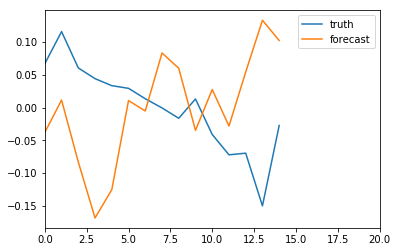

Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


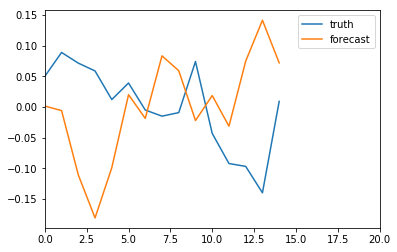

Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


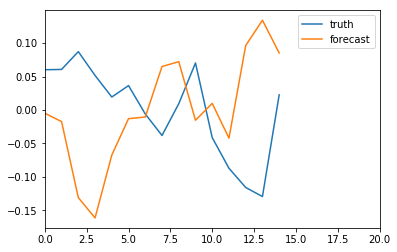

Month 3
Trained using month 3...
Validating against month 3
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


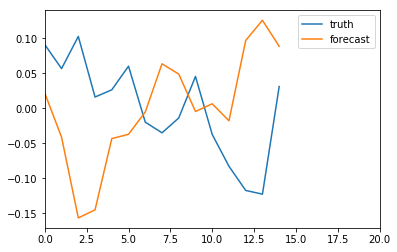

Month 4
Trained using month 4...
Validating against month 4
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


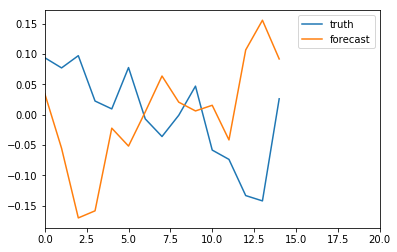

Month 5
Trained using month 5...
Validating against month 5
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


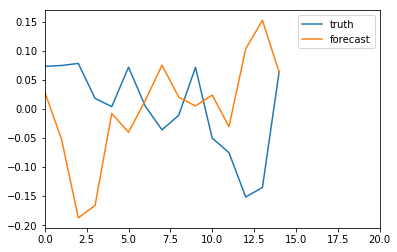

Month 6
Trained using month 6...
Validating against month 6
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


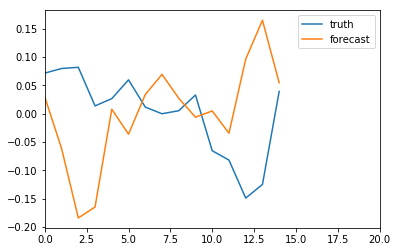

Month 7
Trained using month 7...
Validating against month 7
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


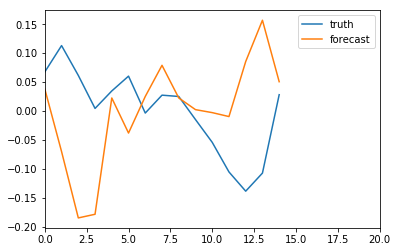

Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


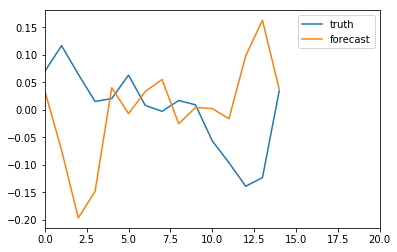

Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


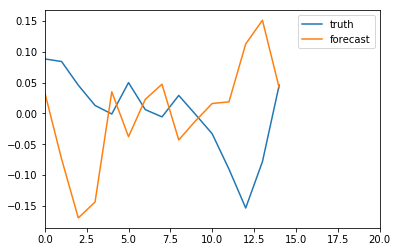

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


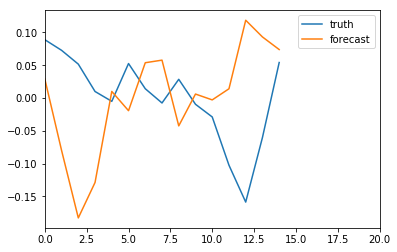

Loading from psl
Loading from ta/MPI/psl_Amon_MPI-ESM-P_historical_r1i1p1_185001-200512.nc
removing climotology...
detrending...
(18432, 1872)
(18432, 1872)
-----------------------------------------------------
completed in 2.8270294666290283 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


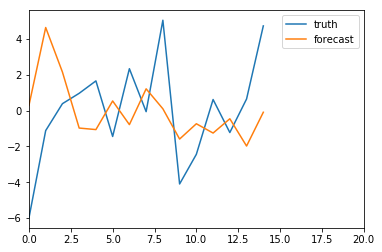

Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


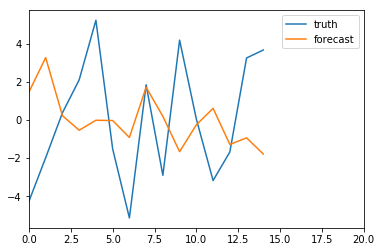

Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


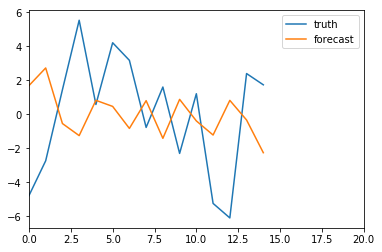

Month 3
Trained using month 3...
Validating against month 3
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


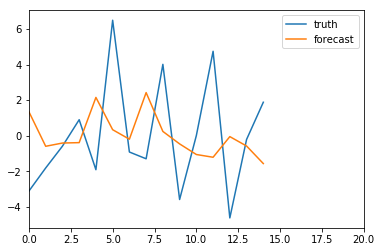

Month 4
Trained using month 4...
Validating against month 4
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


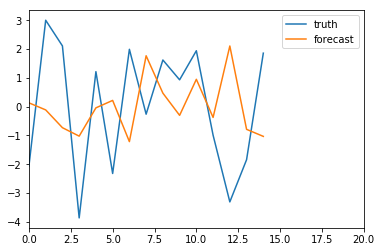

Month 5
Trained using month 5...
Validating against month 5
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


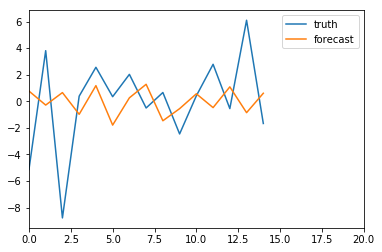

Month 6
Trained using month 6...
Validating against month 6
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


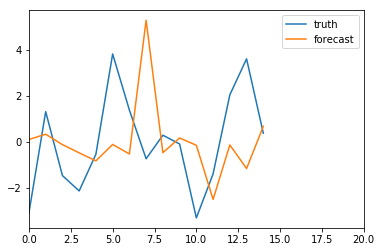

Month 7
Trained using month 7...
Validating against month 7
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


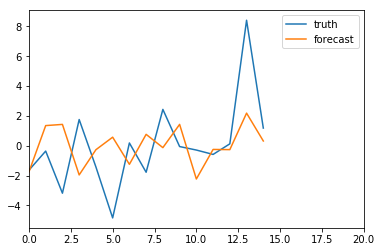

Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


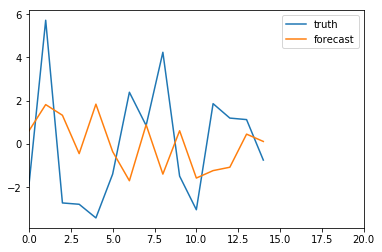

Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


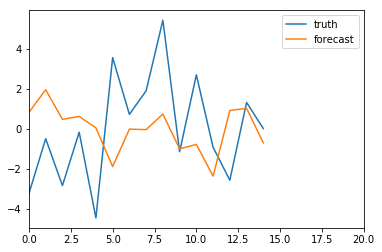

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (18432, 15)
Forecast_anom shape: (18432, 15)


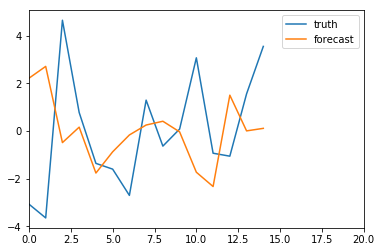

Loading from sit
Loading from a/MPI/sit_OImon_MPI-ESM-P_historical_r1i1p1_185001-200512.nc
removing climotology...
detrending...
(56320, 1872)
(56320, 1872)
-----------------------------------------------------
completed in 7.561597108840942 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


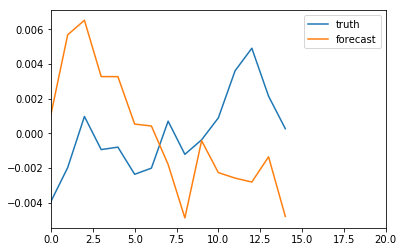

Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


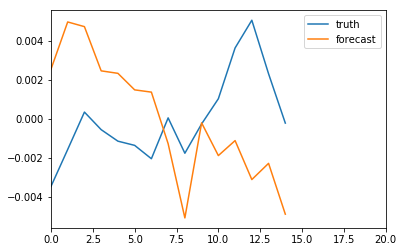

Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


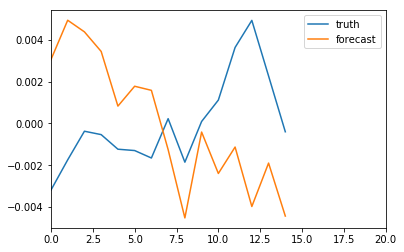

Month 3
Trained using month 3...
Validating against month 3
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


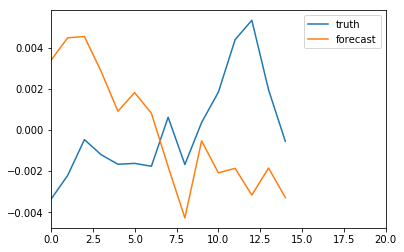

Month 4
Trained using month 4...
Validating against month 4
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


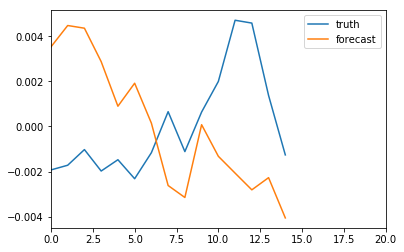

Month 5
Trained using month 5...
Validating against month 5
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


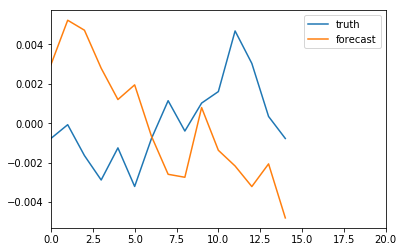

Month 6
Trained using month 6...
Validating against month 6
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


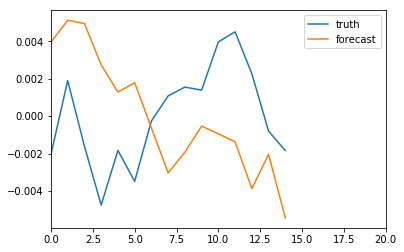

Month 7
Trained using month 7...
Validating against month 7
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


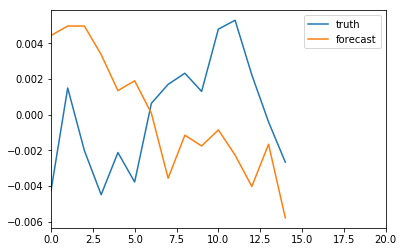

Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


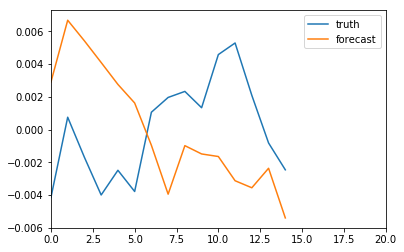

Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


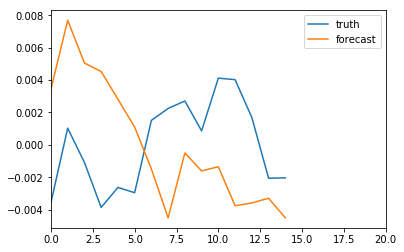

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


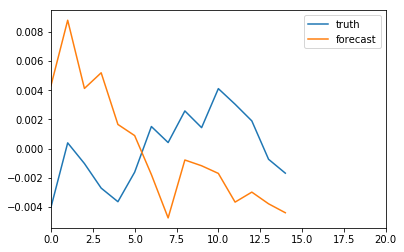

Loading from sic
Loading from a/MPI/sic_OImon_MPI-ESM-P_historical_r1i1p1_185001-200512.nc
removing climotology...
detrending...
(56320, 1872)
(56320, 1872)
-----------------------------------------------------
completed in 7.6258180141448975 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


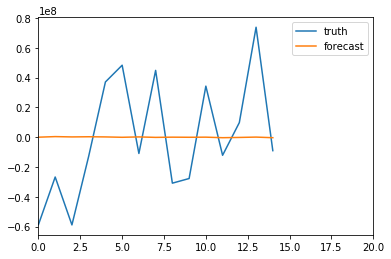

Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


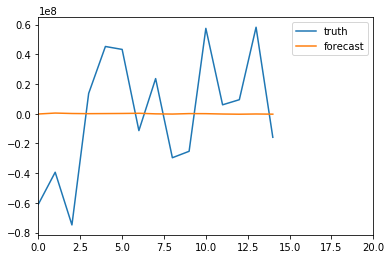

Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


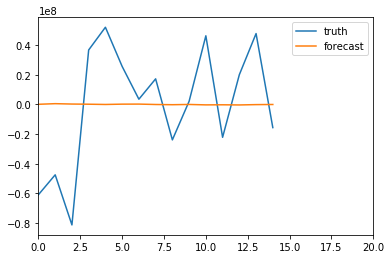

Month 3
Trained using month 3...
Validating against month 3
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


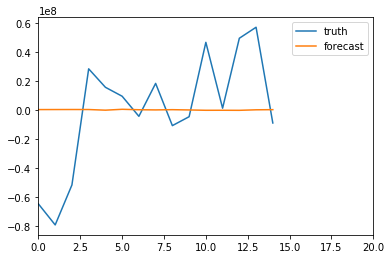

Month 4
Trained using month 4...
Validating against month 4
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


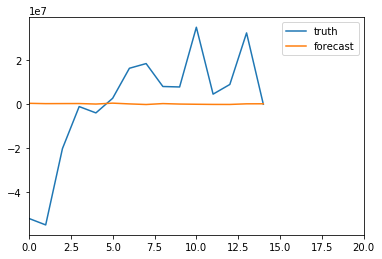

Month 5
Trained using month 5...
Validating against month 5
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


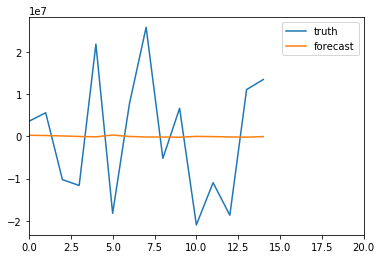

Month 6
Trained using month 6...
Validating against month 6
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


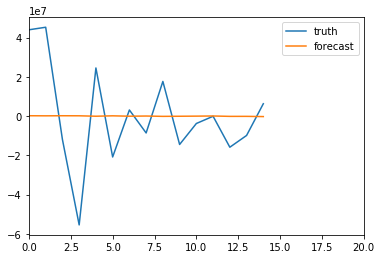

Month 7
Trained using month 7...
Validating against month 7
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


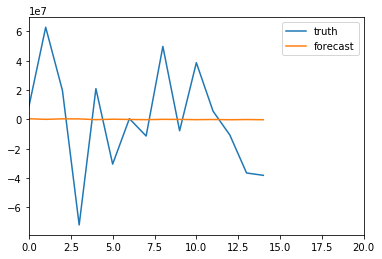

Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


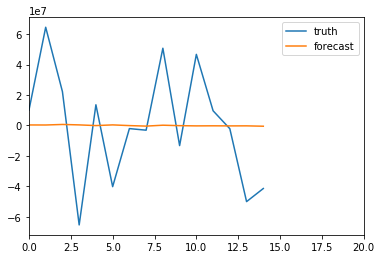

Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


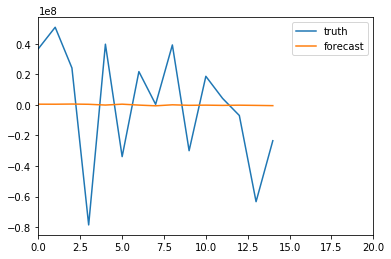

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (56320, 15)
Forecast_anom shape: (56320, 15)


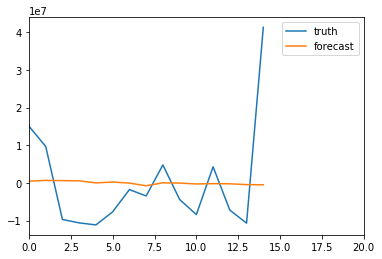

In [101]:
#validvars = ['tas','tos','sic']
validvars = limvars
# validvars = ['psl']
months=[0,1,2,3,4,5,6,7,8,9,10]
lag=1
validation_stats = {}

for k, var in enumerate(validvars):
    valid_stats = {}
    v = {}
    X_var, _ = limkb.load_data(var, v, fdic_valid, remove_climo=True, detrend=True, verbose=True)
    
    corr_tot = np.zeros((len(months)))
    ce_tot = np.zeros((len(months)))
    gm_var_ratio = np.zeros((len(months)))
    
    for i,m in enumerate(months):
        print('Month '+str(m))
        [truth_anom, forecast_anom] = limbuild.gather_truth_forecast_allmo(lag,var,m,X_var,
                                                                           x_forecast_dcomp_mo[:,:,:,m],
                                                                           var_dict,ntrain_valid,0,insamp=False)
        print('Truth_anom shape: '+str(truth_anom.shape))
        print('Forecast_anom shape: '+str(forecast_anom.shape))

#         [corr_tot[i], ce_tot[i], gm_var_ratio[i], tot_var_forecast, 
#          tot_var_truth] = limbuild.calc_validataion_stats(var, truth_anom[:,70:111], forecast_anom, var_dict,
#                                                           areacell,areacell_dict,
#                                                           areawt_name,month_names,iplot=True)
        [corr_tot[i], ce_tot[i], gm_var_ratio[i], tot_var_forecast, 
         tot_var_truth] = limbuild.calc_validataion_stats(var, truth_anom, forecast_anom, var_dict,
                                                          areacell,areacell_dict,
                                                          areawt_name,month_names,iplot=True)
        
    valid_stats['corr_tot'] = corr_tot
    valid_stats['ce_tot'] = ce_tot
    valid_stats['gm_var_ratio'] = gm_var_ratio
    
    validation_stats[var] = valid_stats
    
    del X_var

In [ ]:
for i,var in enumerate(validvars):
    print(var +': ' + str(np.mean(validation_stats[var]['corr_tot']**2)))

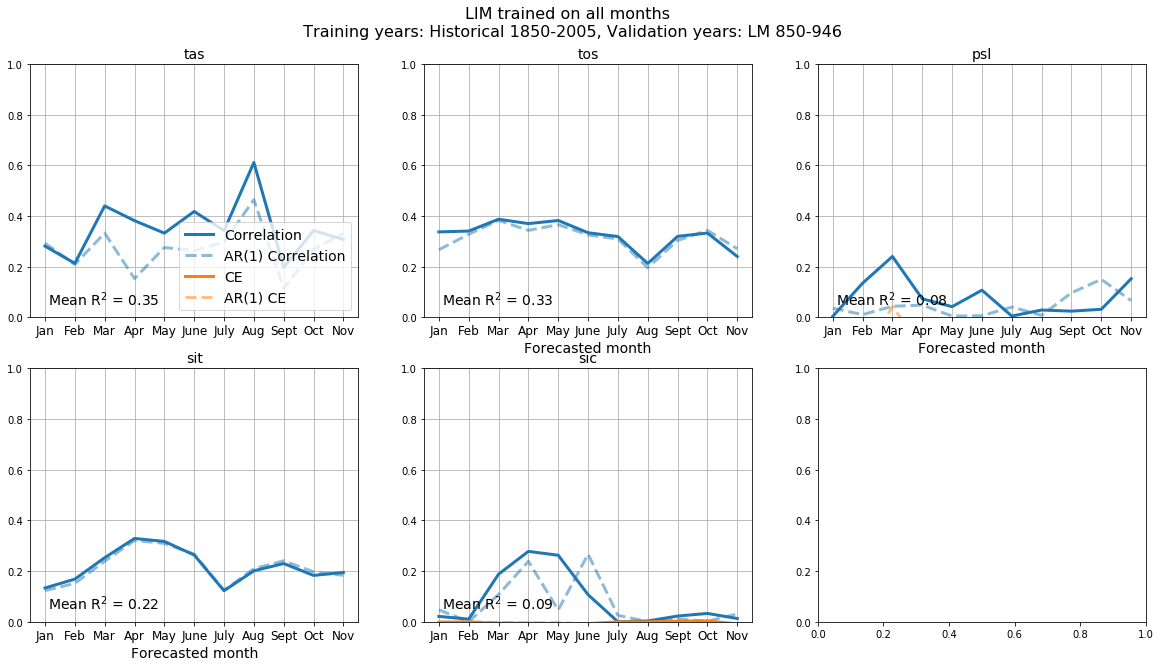

In [104]:
fig,axs = plt.subplots(2,3,figsize=(20,10))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(limvars):
    ax[i].plot(validation_stats[var]['corr_tot']**2, label='Correlation',linewidth=3.0)
    ax[i].plot(validation_stats_ar1[var]['corr_tot']**2, label='AR(1) Correlation',linewidth=3.0, 
               linestyle='--', color='tab:blue',alpha=0.5)

    ax[i].plot(validation_stats[var]['ce_tot'],label='CE',linewidth=3.0)
    ax[i].plot(validation_stats_ar1[var]['ce_tot'],label='AR(1) CE',linewidth=3.0, 
               linestyle='--', color='tab:orange', alpha=0.5)

    ax[i].set_ylim(0,1)
#     ax[i].set_xlim(0,10)
    ax[i].set_xticks(np.arange(0,11,1))
    ax[i].set_xticklabels(month_names,fontsize=12)
    ax[i].grid(axis='both')
    ax[i].set_title(var, fontsize=14)
    ax[i].text(0.1,0.05, ("Mean R$^2$ = "+str(np.round(np.mean(validation_stats[var]['corr_tot']**2),2))),fontsize=14)

if Insamp==True:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
# #                  ', Validation years: Historical'+str(850)+'-'+str(int(850+ntrain*1000))), fontsize=16)
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)

else:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+
#                   str(int(850+ntrain*1000))+', Validation years: '+
#                   str(int(850+ntrain*1000))+'-'+str(int(850+ntrain*1000+nvalidtimes/12))), fontsize=16)
    plt.suptitle(('LIM trained on all months \n Training years: Historical 1850-2005'+
                  ', Validation years: LM '+str(850)+'-'+str(int(850+ntrain_valid*1000))), fontsize=16)

# ax[i].text(0.1,0.05, ("Training years: "+str(850)+'-'+str(850+ntrain*1000)),fontsize=14)
# ax[i].text(0.1,0.05, ("Validation years: "+str(850+ntrain*1000)+'-1850'),fontsize=14)


ax[0].legend(loc='lower right', fontsize=14)
ax[2].set_xlabel('Forecasted month', fontsize=14)
ax[1].set_xlabel('Forecasted month', fontsize=14)
ax[3].set_xlabel('Forecasted month', fontsize=14)

plt.subplots_adjust(top=0.9)

In [ ]:
for i,var in enumerate(limvars):
    print(var +': ' + str(np.mean(validation_stats[var]['gm_var_ratio'])))

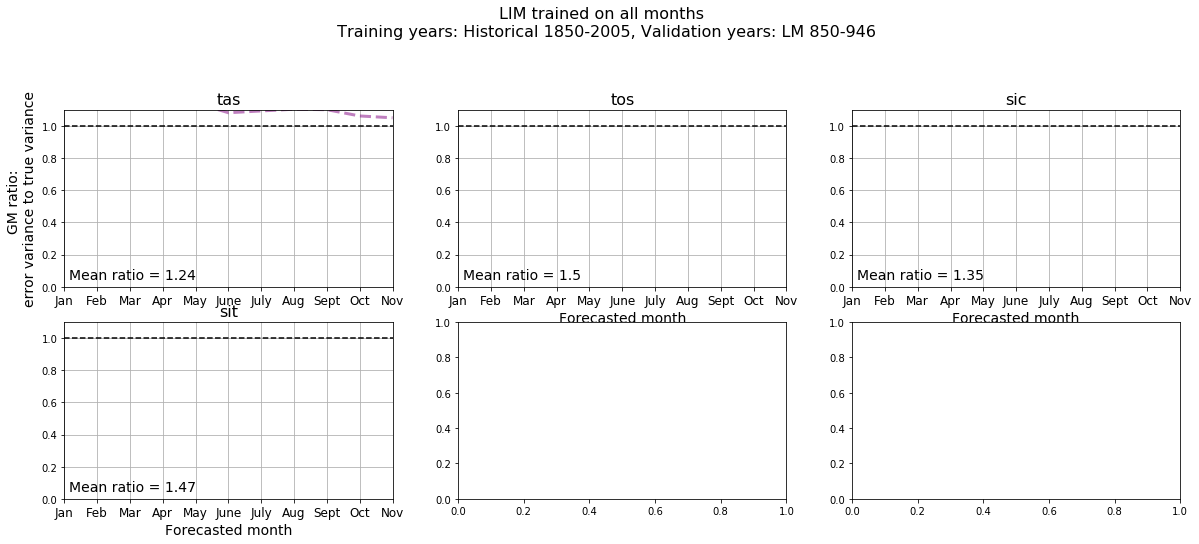

In [105]:
fig,axs = plt.subplots(2,3,figsize=(20,8))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(['tas','tos','sic','sit']):
    ax[i].plot(validation_stats[var]['gm_var_ratio'],linewidth=3.0, color='purple')

    ax[i].plot(validation_stats_ar1[var]['gm_var_ratio'],linewidth=3.0, color='purple', 
               linestyle='--', alpha=0.5)

#    ax[i].set_ylim(0,1)
    ax[i].set_xlim(0,10)
    ax[i].set_ylim(0,1.1)
    ax[i].set_xticks(np.arange(0,11,1))
    ax[i].set_xticklabels(month_names,fontsize=12)
    ax[i].grid(axis='both')
    ax[i].set_title(var, fontsize=16)
    ax[i].text(0.15,0.05, ("Mean ratio = "+str(np.round(np.mean(validation_stats[var]['gm_var_ratio']),2))),
               fontsize=14)
    ax[i].axhline(1.0,color='k',linestyle='--')

if Insamp==True:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
#                  ', Validation years: Historical'+str(850)+'-'+str(int(850+ntrain*1000))), fontsize=16)
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)
else:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+
#                   str(int(850+ntrain*1000))+', Validation years: '+
#                   str(int(850+ntrain*1000))+'-'+str(int(850+ntrain*1000+nvalidtimes/12))), fontsize=16)
    plt.suptitle(('LIM trained on all months \n Training years: Historical 1850-2005, Validation years: LM '+
                  str(850)+'-'+str(int(850+ntrain_valid*1000))), fontsize=16)
    
ax[2].set_xlabel('Forecasted month', fontsize=14)
ax[1].set_xlabel('Forecasted month', fontsize=14)
ax[3].set_xlabel('Forecasted month', fontsize=14)
ax[0].set_ylabel('GM ratio: \nerror variance to true variance', fontsize=14)

plt.subplots_adjust(top=0.8)
#plt.tight_layout()

### Validate all lags: 

In [106]:
ar1_forecast_dcomp_lag = np.zeros((len(lags[1:]),E3_all.shape[0]+ E_sic.shape[0],nyearsvalid*12))

for l,lag in enumerate(lags[1:]):
    forecast, ar1_factor = statskb.red_noise_forecast_ar1(P_train.T, P_train_valid.T, lead=lag)

    nmodes = E3_all.shape[1]
    ar1_forecast_dcomp = np.zeros((E3_all.shape[0]+ E_sic.shape[0],nyearsvalid*12))

    ar1_forecast_dcomp_lag[l,:,lag:] = limkb.decompress_eof_separate_sic(forecast.T,nmodes,nmodes_sic,E3_all,
                                                                       E_sic,limvars,var_dict,W_all,Weights=True,
                                                                       sic_separate=sic_separate)

Loading from tas
Loading from ta/MPI/tas_Amon_MPI-ESM-P_historical_r1i1p1_185001-200512.nc
removing climotology...
detrending...
(18432, 1872)
(18432, 1872)
-----------------------------------------------------
completed in 3.225507974624634 seconds
-----------------------------------------------------
Lag 1
Trained using all months...
Truth_anom shape: (18432, 180)
Forecast_anom shape: (18432, 180)


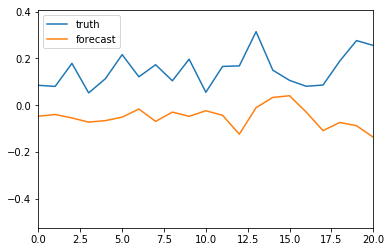

Lag 2
Trained using all months...
Truth_anom shape: (18432, 179)
Forecast_anom shape: (18432, 179)


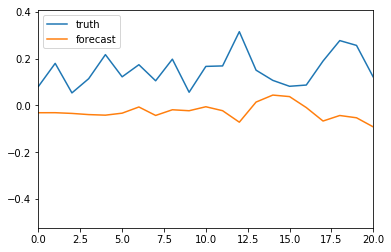

Lag 3
Trained using all months...
Truth_anom shape: (18432, 178)
Forecast_anom shape: (18432, 178)


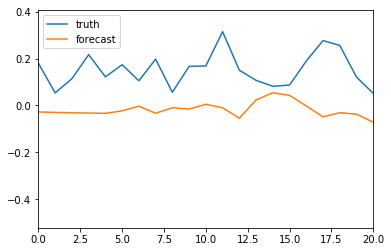

Lag 4
Trained using all months...
Truth_anom shape: (18432, 177)
Forecast_anom shape: (18432, 177)


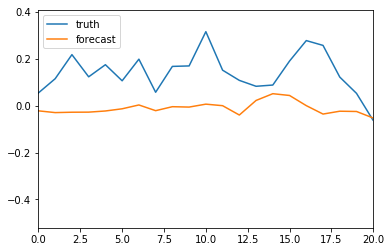

Loading from tos
Loading from ta/MPI/tos_Omon_MPI-ESM-P_historical_r1i1p1_185001-200512.nc
removing climotology...
detrending...
(56320, 1872)
(56320, 1872)
-----------------------------------------------------
completed in 7.634406566619873 seconds
-----------------------------------------------------
Lag 1
Trained using all months...
Truth_anom shape: (56320, 180)
Forecast_anom shape: (56320, 180)


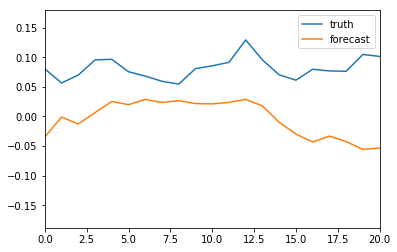

Lag 2
Trained using all months...
Truth_anom shape: (56320, 179)
Forecast_anom shape: (56320, 179)


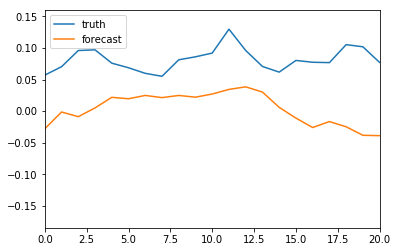

Lag 3
Trained using all months...
Truth_anom shape: (56320, 178)
Forecast_anom shape: (56320, 178)


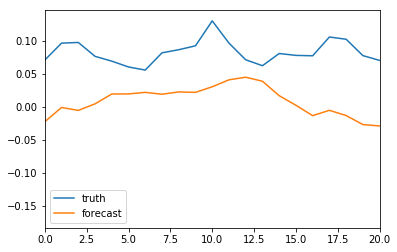

Lag 4
Trained using all months...
Truth_anom shape: (56320, 177)
Forecast_anom shape: (56320, 177)


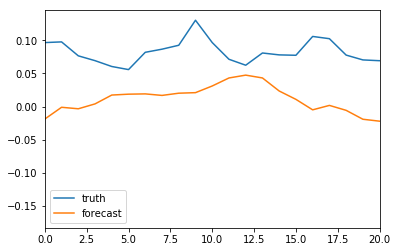

Loading from psl
Loading from ta/MPI/psl_Amon_MPI-ESM-P_historical_r1i1p1_185001-200512.nc
removing climotology...
detrending...
(18432, 1872)
(18432, 1872)
-----------------------------------------------------
completed in 2.8406331539154053 seconds
-----------------------------------------------------
Lag 1
Trained using all months...
Truth_anom shape: (18432, 180)
Forecast_anom shape: (18432, 180)


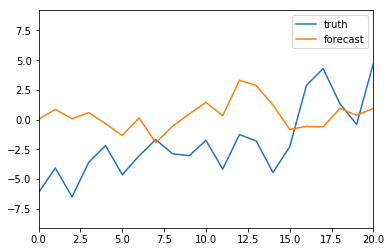

Lag 2
Trained using all months...
Truth_anom shape: (18432, 179)
Forecast_anom shape: (18432, 179)


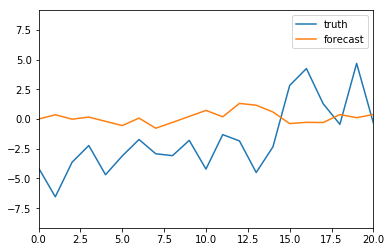

Lag 3
Trained using all months...
Truth_anom shape: (18432, 178)
Forecast_anom shape: (18432, 178)


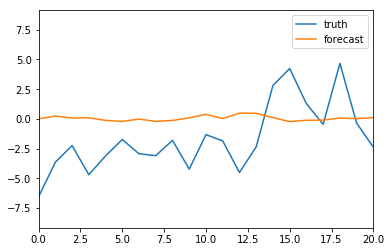

Lag 4
Trained using all months...
Truth_anom shape: (18432, 177)
Forecast_anom shape: (18432, 177)


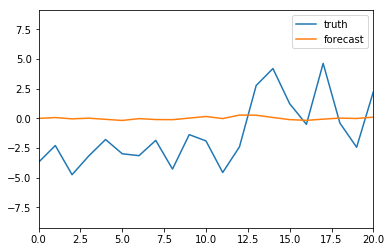

Loading from sit
Loading from a/MPI/sit_OImon_MPI-ESM-P_historical_r1i1p1_185001-200512.nc
removing climotology...
detrending...
(56320, 1872)
(56320, 1872)
-----------------------------------------------------
completed in 7.680879354476929 seconds
-----------------------------------------------------
Lag 1
Trained using all months...
Truth_anom shape: (56320, 180)
Forecast_anom shape: (56320, 180)


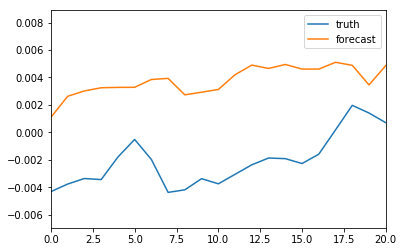

Lag 2
Trained using all months...
Truth_anom shape: (56320, 179)
Forecast_anom shape: (56320, 179)


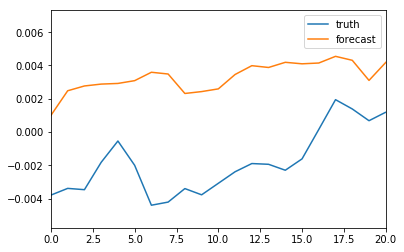

Lag 3
Trained using all months...
Truth_anom shape: (56320, 178)
Forecast_anom shape: (56320, 178)


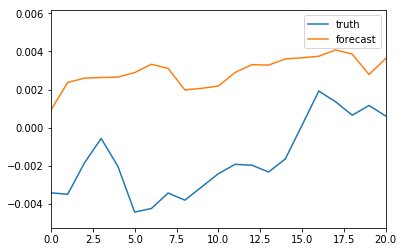

Lag 4
Trained using all months...
Truth_anom shape: (56320, 177)
Forecast_anom shape: (56320, 177)


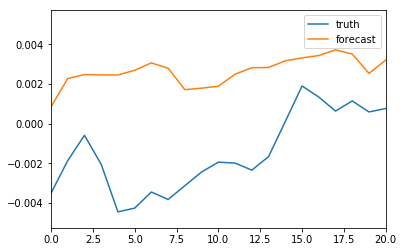

Loading from sic
Loading from a/MPI/sic_OImon_MPI-ESM-P_historical_r1i1p1_185001-200512.nc
removing climotology...
detrending...
(56320, 1872)
(56320, 1872)
-----------------------------------------------------
completed in 7.550822019577026 seconds
-----------------------------------------------------
Lag 1
Trained using all months...
Truth_anom shape: (56320, 180)
Forecast_anom shape: (56320, 180)


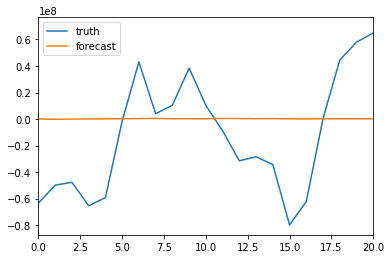

Lag 2
Trained using all months...
Truth_anom shape: (56320, 179)
Forecast_anom shape: (56320, 179)


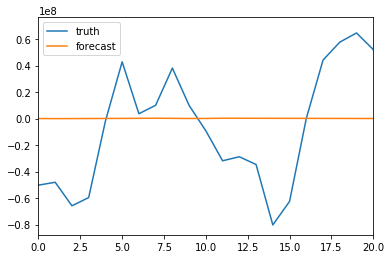

Lag 3
Trained using all months...
Truth_anom shape: (56320, 178)
Forecast_anom shape: (56320, 178)


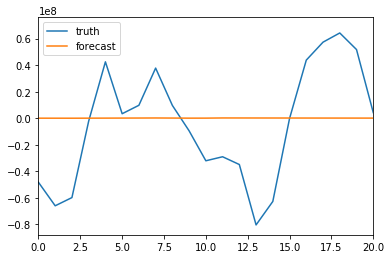

Lag 4
Trained using all months...
Truth_anom shape: (56320, 177)
Forecast_anom shape: (56320, 177)


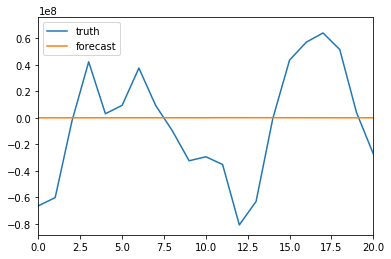

In [107]:
#validvars = ['tas','tos','sic']
validvars = limvars
# validvars = ['psl']
lag=None
validation_stats_ar1_lags = {}
st=0

for k, var in enumerate(validvars):
    valid_stats_ar1_lags = {}
    v = {}
    X_var, _ = limkb.load_data(var, v, fdic_valid, remove_climo=True, detrend=True, verbose=True)
    
    corr_tot = np.zeros((len(lags)))
    ce_tot = np.zeros((len(lags)))
    gm_var_ratio = np.zeros((len(lags)))
    
    for i,lag in enumerate(lags[1:]):
        print('Lag '+str(lag))
        [truth_anom, forecast_anom] = limbuild.gather_truth_forecast(i,var,mo,X_var,ar1_forecast_dcomp_lag,
                                                                     nvalidtimes,var_dict,ntrain_valid,
                                                                     insamp=True)
#         st = st + var_dict[var]['var_ndof']
        
        print('Truth_anom shape: '+str(truth_anom.shape))
        print('Forecast_anom shape: '+str(forecast_anom.shape))

#         [corr_tot[i], ce_tot[i], gm_var_ratio[i], tot_var_forecast, 
#          tot_var_truth] = limbuild.calc_validataion_stats(var, truth_anom[:,70:111], forecast_anom, var_dict,
#                                                           areacell,areacell_dict,
#                                                           areawt_name,month_names,iplot=True)
        [corr_tot[i], ce_tot[i], gm_var_ratio[i], tot_var_forecast, 
         tot_var_truth] = limbuild.calc_validataion_stats(var, truth_anom, forecast_anom, var_dict,
                                                          areacell,areacell_dict,
                                                          areawt_name,month_names,iplot=True)
        
    valid_stats_ar1_lags['corr_tot'] = corr_tot
    valid_stats_ar1_lags['ce_tot'] = ce_tot
    valid_stats_ar1_lags['gm_var_ratio'] = gm_var_ratio
    
    validation_stats_ar1_lags[var] = valid_stats_ar1_lags
    
    del X_var

Loading from tas
Loading from ta/MPI/tas_Amon_MPI-ESM-P_historical_r1i1p1_185001-200512.nc
removing climotology...
detrending...
(18432, 1872)
(18432, 1872)
-----------------------------------------------------
completed in 2.9319381713867188 seconds
-----------------------------------------------------
Lag 0
Trained using all months...
Truth_anom shape: (18432, 180)
Forecast_anom shape: (18432, 180)


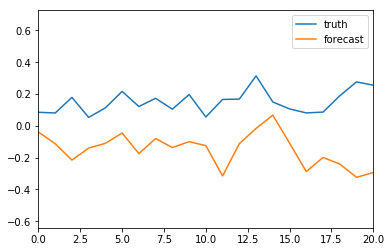

Lag 1
Trained using all months...
Truth_anom shape: (18432, 179)
Forecast_anom shape: (18432, 179)


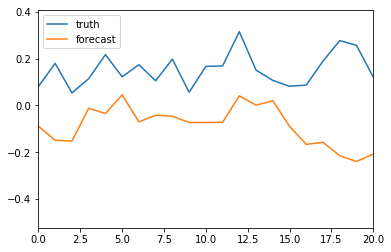

Lag 2
Trained using all months...
Truth_anom shape: (18432, 178)
Forecast_anom shape: (18432, 178)


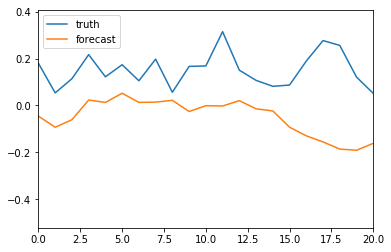

Lag 3
Trained using all months...
Truth_anom shape: (18432, 177)
Forecast_anom shape: (18432, 177)


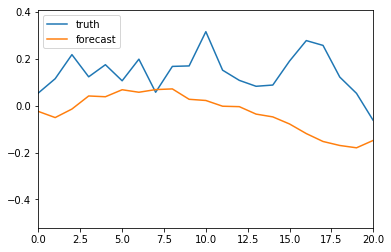

Loading from tos
Loading from ta/MPI/tos_Omon_MPI-ESM-P_historical_r1i1p1_185001-200512.nc
removing climotology...
detrending...
(56320, 1872)
(56320, 1872)
-----------------------------------------------------
completed in 7.598940849304199 seconds
-----------------------------------------------------
Lag 0
Trained using all months...
Truth_anom shape: (56320, 180)
Forecast_anom shape: (56320, 180)


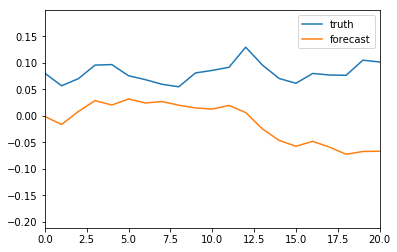

Lag 1
Trained using all months...
Truth_anom shape: (56320, 179)
Forecast_anom shape: (56320, 179)


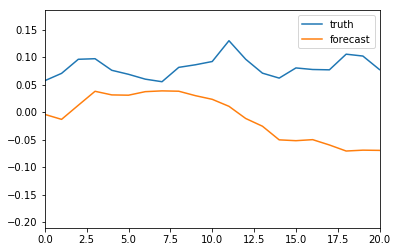

Lag 2
Trained using all months...
Truth_anom shape: (56320, 178)
Forecast_anom shape: (56320, 178)


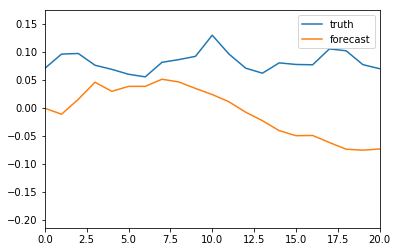

Lag 3
Trained using all months...
Truth_anom shape: (56320, 177)
Forecast_anom shape: (56320, 177)


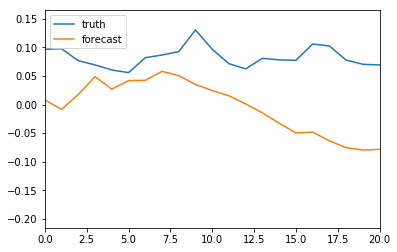

Loading from psl
Loading from ta/MPI/psl_Amon_MPI-ESM-P_historical_r1i1p1_185001-200512.nc
removing climotology...
detrending...
(18432, 1872)
(18432, 1872)
-----------------------------------------------------
completed in 2.8489930629730225 seconds
-----------------------------------------------------
Lag 0
Trained using all months...
Truth_anom shape: (18432, 180)
Forecast_anom shape: (18432, 180)


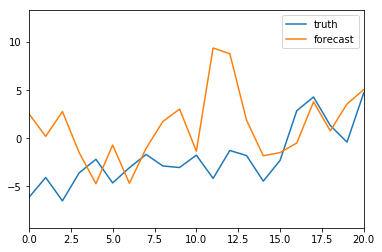

Lag 1
Trained using all months...
Truth_anom shape: (18432, 179)
Forecast_anom shape: (18432, 179)


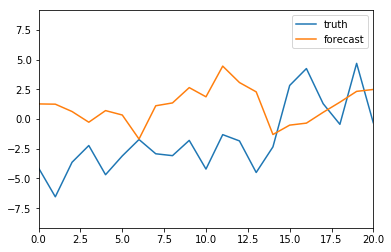

Lag 2
Trained using all months...
Truth_anom shape: (18432, 178)
Forecast_anom shape: (18432, 178)


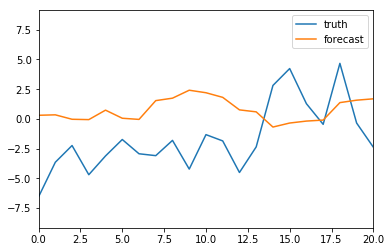

Lag 3
Trained using all months...
Truth_anom shape: (18432, 177)
Forecast_anom shape: (18432, 177)


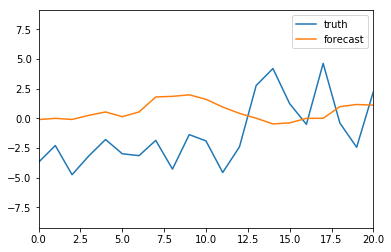

Loading from sit
Loading from a/MPI/sit_OImon_MPI-ESM-P_historical_r1i1p1_185001-200512.nc
removing climotology...
detrending...
(56320, 1872)
(56320, 1872)
-----------------------------------------------------
completed in 7.740501880645752 seconds
-----------------------------------------------------
Lag 0
Trained using all months...
Truth_anom shape: (56320, 180)
Forecast_anom shape: (56320, 180)


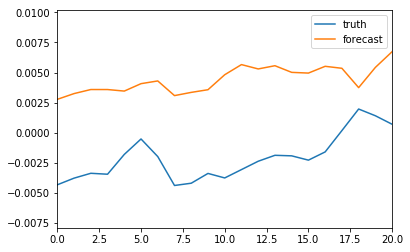

Lag 1
Trained using all months...
Truth_anom shape: (56320, 179)
Forecast_anom shape: (56320, 179)


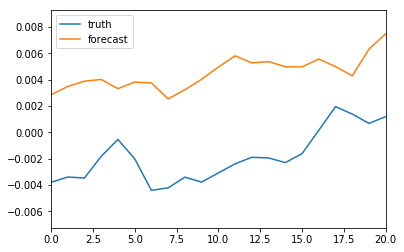

Lag 2
Trained using all months...
Truth_anom shape: (56320, 178)
Forecast_anom shape: (56320, 178)


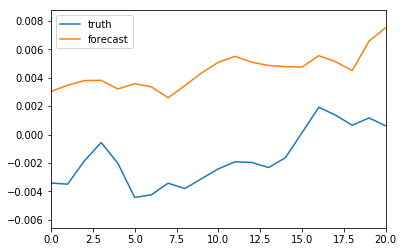

Lag 3
Trained using all months...
Truth_anom shape: (56320, 177)
Forecast_anom shape: (56320, 177)


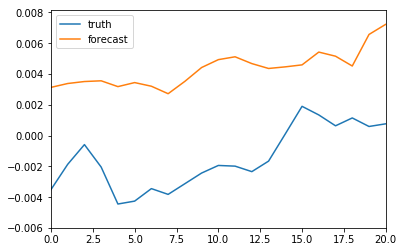

Loading from sic
Loading from a/MPI/sic_OImon_MPI-ESM-P_historical_r1i1p1_185001-200512.nc
removing climotology...
detrending...
(56320, 1872)
(56320, 1872)
-----------------------------------------------------
completed in 7.6711413860321045 seconds
-----------------------------------------------------
Lag 0
Trained using all months...
Truth_anom shape: (56320, 180)
Forecast_anom shape: (56320, 180)


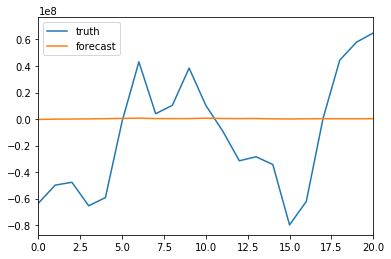

Lag 1
Trained using all months...
Truth_anom shape: (56320, 179)
Forecast_anom shape: (56320, 179)


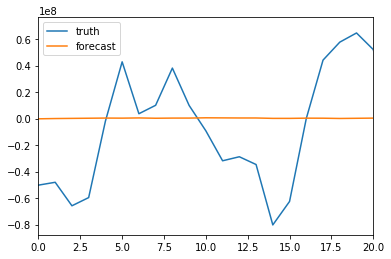

Lag 2
Trained using all months...
Truth_anom shape: (56320, 178)
Forecast_anom shape: (56320, 178)


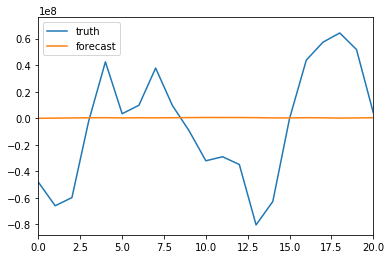

Lag 3
Trained using all months...
Truth_anom shape: (56320, 177)
Forecast_anom shape: (56320, 177)


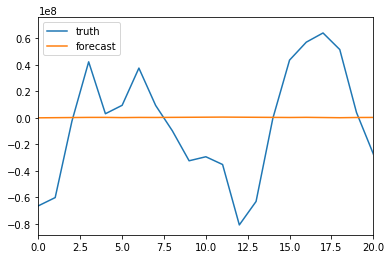

In [108]:
#validvars = ['tas','tos','sic']
validvars = limvars
v = {}
validation_stats_lag = {}
lags_test = [0,1,2,3]
#lags_test = [0, 1]
gm_variance_mo = {}
valid_stats_lags = {}

for k, var in enumerate(validvars):
    X_var, _ = limkb.load_data(var, v, fdic_valid, remove_climo=True, detrend=True, verbose=True)
    
    var_3d = np.reshape(X_var,(X_var.shape[0],int(X_var.shape[1]/12),12))
    x_anom_var = np.nanvar(var_3d,axis=1,ddof=1)
    gm_x_var = statskb.global_mean(x_anom_var,areacell[areawt_name[var]])
    
    gm_variance_mo[var] = gm_x_var
    
    corr_tot = np.zeros((len(lags)))
    ce_tot = np.zeros((len(lags)))
    gm_var_ratio = np.zeros((len(lags)))
    valid_stats = {}

    for i,lag in enumerate(lags_test):
        print('Lag '+str(lag))
        [truth_anom, forecast_anom] = limbuild.gather_truth_forecast(lag,var,mo,X_var,x_forecast_dcomp,
                                                                     nvalidtimes,var_dict,ntrain_valid,
                                                                     insamp=True)
        print('Truth_anom shape: '+str(truth_anom.shape))
        print('Forecast_anom shape: '+str(forecast_anom.shape))

        [corr_tot[i], ce_tot[i], gm_var_ratio[i], tot_var_forecast, 
         tot_var_truth] = limbuild.calc_validataion_stats(var, truth_anom, forecast_anom, var_dict,
                                                          areacell,areacell_dict,
                                                          areawt_name,month_names,iplot=True)
        
    valid_stats['corr_tot'] = corr_tot
    valid_stats['ce_tot'] = ce_tot
    valid_stats['gm_var_ratio'] = gm_var_ratio
    
    validation_stats_lag[var] = valid_stats
    
# valid_stats_allmo[var] = validation_stats

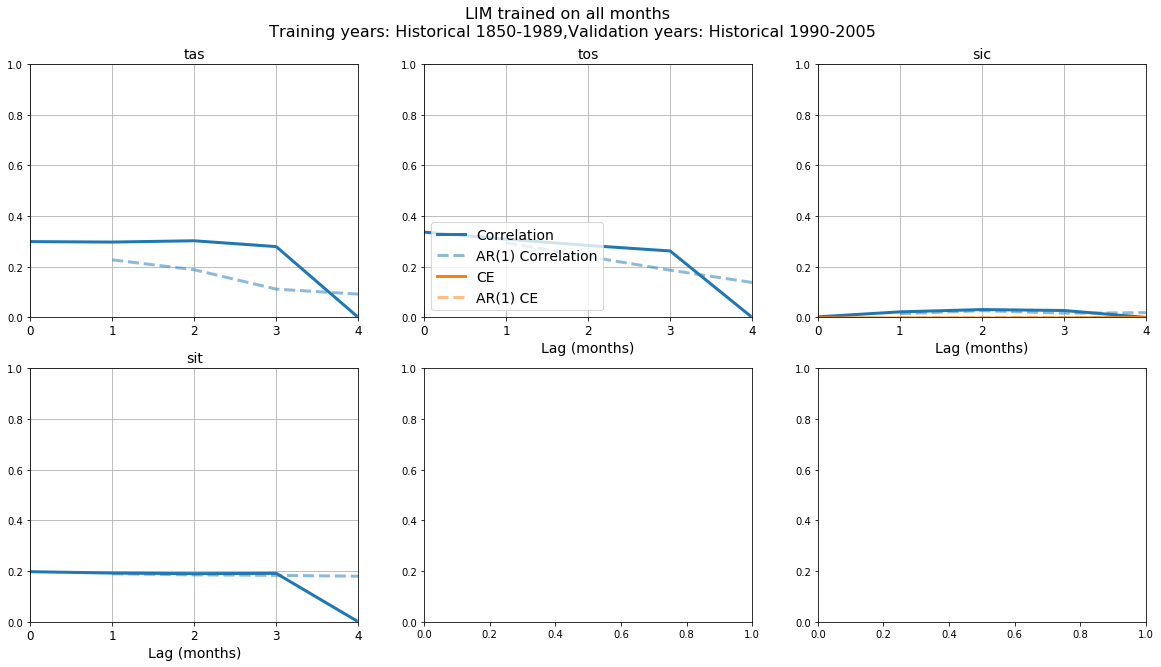

In [112]:
fig,axs = plt.subplots(2,3,figsize=(20,10))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(['tas','tos','sic','sit']):
    ax[i].plot(validation_stats_lag[var]['corr_tot']**2, label='Correlation',linewidth=3.0)
    ax[i].plot(np.arange(1,5,1),validation_stats_ar1_lags[var]['corr_tot'][:-1]**2, label='AR(1) Correlation',linewidth=3.0, 
               linestyle='--', color='tab:blue',alpha=0.5)

    ax[i].plot(validation_stats_lag[var]['ce_tot'],label='CE',linewidth=3.0)
    ax[i].plot(np.arange(1,5,1),validation_stats_ar1_lags[var]['ce_tot'][:-1],label='AR(1) CE',linewidth=3.0, 
               linestyle='--', color='tab:orange', alpha=0.5)

    ax[i].set_xticks(np.arange(0,11,1))
    ax[i].set_xticklabels(np.arange(0,11,1),fontsize=12)
    ax[i].set_ylim(0,1)
    ax[i].set_xlim(0,4)
    ax[i].grid(axis='both')
    ax[i].set_title(var, fontsize=14)
#    ax[i].text(0.1,0.05, ("Mean R$^2$ = "+str(np.round(np.mean(validation_stats[var]['corr_tot']**2),2))),fontsize=14)
    
if Insamp==True:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
#                  ', Validation years: Historical'+str(850)+'-'+str(int(850+ntrain*1000))), fontsize=16)
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)
else:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+
#                   str(int(850+ntrain*1000))+', Validation years: '+
#                   str(int(850+ntrain*1000))+'-'+str(int(850+ntrain*1000+nvalidtimes/12))), fontsize=16)
    plt.suptitle(('LIM trained on all months \n Training years: Historical 1850-1989,'+
                  'Validation years: Historical 1990-2005'), fontsize=16)

# ax[i].text(0.1,0.05, ("Training years: "+str(850)+'-'+str(850+ntrain*1000)),fontsize=14)
# ax[i].text(0.1,0.05, ("Validation years: "+str(850+ntrain*1000)+'-1850'),fontsize=14)


ax[1].legend(loc='lower left', fontsize=14)
ax[2].set_xlabel('Lag (months)', fontsize=14)
ax[1].set_xlabel('Lag (months)', fontsize=14)
ax[3].set_xlabel('Lag (months)', fontsize=14)

plt.subplots_adjust(top=0.9)

In [110]:
ntrain_valid

0.09615384615384616

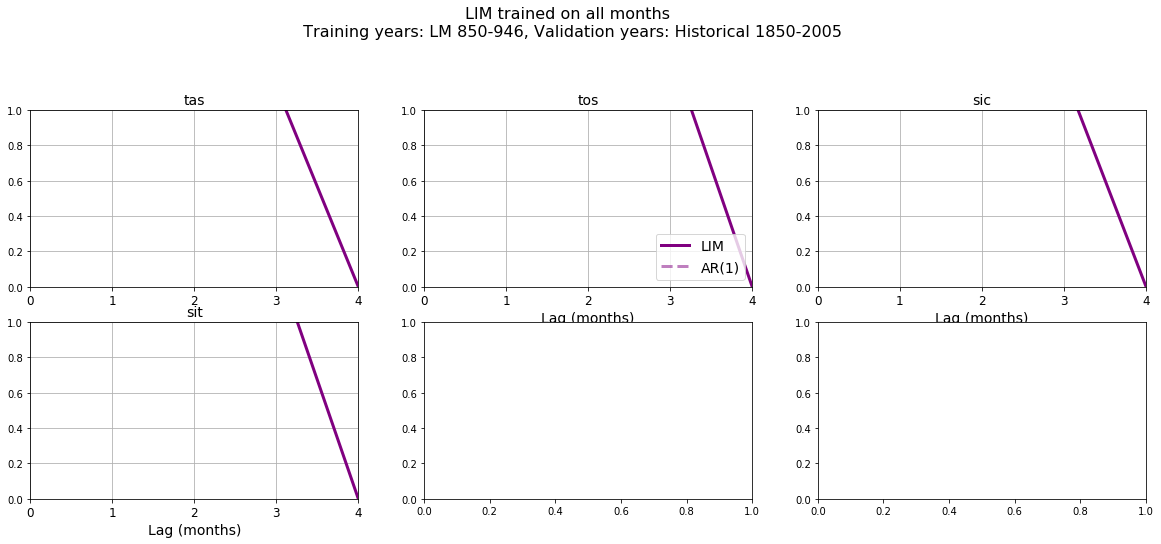

In [114]:
fig,axs = plt.subplots(2,3,figsize=(20,8))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(['tas','tos','sic','sit']):
    ax[i].plot(validation_stats_lag[var]['gm_var_ratio'], label='LIM',linewidth=3.0, color='purple')
    ax[i].plot(np.arange(1,5,1),validation_stats_ar1_lags[var]['gm_var_ratio'][:-1], label='AR(1)',linewidth=3.0, 
               linestyle='--', color='purple',alpha=0.5)

    ax[i].set_xticks(np.arange(0,11,1))
    ax[i].set_xticklabels(np.arange(0,11,1),fontsize=12)
    ax[i].set_ylim(0,1)
    ax[i].set_xlim(0,4)
    ax[i].grid(axis='both')
    ax[i].set_title(var, fontsize=14)
    
if Insamp==True:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
#                  ', Validation years: Historical'+str(850)+'-'+str(int(850+ntrain*1000))), fontsize=16)
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)
else:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+
#                   str(int(850+ntrain*1000))+', Validation years: '+
#                   str(int(850+ntrain*1000))+'-'+str(int(850+ntrain*1000+nvalidtimes/12))), fontsize=16)
    plt.suptitle(('LIM trained on all months \n Training years: LM '+
                  str(850)+'-'+str(int(850+ntrain_valid*1000))+
                                   ', Validation years: Historical 1850-2005'), fontsize=16)

# ax[i].text(0.1,0.05, ("Training years: "+str(850)+'-'+str(850+ntrain*1000)),fontsize=14)
# ax[i].text(0.1,0.05, ("Validation years: "+str(850+ntrain*1000)+'-1850'),fontsize=14)


ax[1].legend(loc='lower right', fontsize=14)
ax[2].set_xlabel('Lag (months)', fontsize=14)
ax[1].set_xlabel('Lag (months)', fontsize=14)
ax[3].set_xlabel('Lag (months)', fontsize=14)

plt.subplots_adjust(top=0.8)

#### Variance across variables across months:

In [ ]:
for var in validvars:
    plt.plot(gm_variance_mo[var], label=var)
    
plt.title('Global mean variance in LM simulation')
plt.ylabel('Variance (%$^2$)')
plt.xticks(np.arange(0,12,1),month_names, rotation=45)
plt.legend()

In [ ]:
for var in validvars:
    plt.plot(gm_variance_mo[var]/gm_variance_mo[var].max(), label=var)
    
plt.title('Global mean variance in LM simulation')
plt.ylabel('Variance (%$^2$)')
plt.xticks(np.arange(0,12,1),month_names, rotation=45)
plt.legend()

#### Validate single variable: 

In [ ]:
lags_test = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
validvars = ['sic']
v = {}
validation_stats_test = {}

for k, var in enumerate(validvars):
    X_var, _ = limkb.load_data(var, v, fdic_valid, remove_climo=True, detrend=True, verbose=True)
    
    corr_tot = np.zeros((len(lags)))
    ce_tot = np.zeros((len(lags)))
    gm_var_ratio = np.zeros((len(lags)))
    valid_stats_test = {}

    for i,lag in enumerate(lags_test):
        print('Lag '+str(lag))
        [truth_anom, forecast_anom] = limbuild.gather_truth_forecast(lag,var,mo,X_var,x_forecast_dcomp,
                                                                     var_dict,ntrain,insamp=Insamp)
        print('Truth_anom shape: '+str(truth_anom.shape))
        print('Forecast_anom shape: '+str(forecast_anom.shape))
        
#         if lag == 1: 
#             truth_error_var = np.nanvar(truth_anom,axis=1,ddof=1)
#             truth_error_var = np.where(truth_var<1,0,truth_var)
#             gm_truth_var = statskb.global_mean(truth_error_var,areacell[areawt_name[var]])          
    
#         error_var = np.nanvar(truth_anom-forecast_anom,axis=1,ddof=1)
#         truth_error_var = np.nanvar(truth_anom,axis=1,ddof=1)

#         ratio = error_var/truth_error_var
        
#         area_shape = areacell[areawt_name[var]].shape
#         gm_var_ratio[i] = statskb.global_mean(ratio[np.isfinite(ratio)],
#                                               np.reshape(areacell[areawt_name[var]],(area_shape[0]*area_shape[1]))[np.isfinite(ratio)])

        if lag ==1: 
            truth_error_var = np.nanvar(truth_anom,axis=1,ddof=1)
            area_shape = areacell[areawt_name[var]].shape
            gm_truth_var = statskb.global_mean(truth_error_var[truth_error_var>0],
                                               np.reshape(areacell[areawt_name[var]],(area_shape[0]*area_shape[1]))[truth_error_var>0])

        area_shape = areacell[areawt_name[var]].shape
        error_var = np.nanvar(truth_anom-forecast_anom,axis=1,ddof=1)
        gm_error_var = statskb.global_mean(error_var[truth_error_var>0],
                                           np.reshape(areacell[areawt_name[var]],(area_shape[0]*area_shape[1]))[truth_error_var>0])

        gm_var_ratio[i]=gm_error_var/gm_truth_var
#         print(gm_error_var)
#         print(gm_truth_var)
        
    valid_stats_test['gm_var_ratio'] = gm_var_ratio
    validation_stats_test[var] = valid_stats_test

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(7,4))
#fig,axs= plt.subplots(2, 2)

#ax = axs.flatten()

for i,var in enumerate(['sic']):
    ax.plot(np.arange(1,13,1),validation_stats_test[var]['gm_var_ratio'])

#    ax[i].set_ylim(0,1)
    ax.set_xlim(1,10)
#    ax.set_ylim(0,1.1)
    ax.set_xticks([1,2,3,4,5,6,7,8,9,10])
    ax.grid(axis='both')
    ax.set_ylabel('GM ratio: \nerror variance to true variance', fontsize=14)
    ax.set_title(var, fontsize=16)
if mo == 'all':
    plt.suptitle('All months', fontsize=16)
else: 
    plt.suptitle(month_names[mo], fontsize=16)
    
ax.set_xlabel('lead time (months)', fontsize=14)
ax.set_xlabel('lead time (months)', fontsize=14)

#### Validate SIC: 

In [ ]:
# validvars = ['sic']
# v = {}
# validation_stats = {}

# for k, var in enumerate(validvars):
#     X_var, _ = limkb.load_data(var, v, fdic_train, remove_climo=True, detrend=True, verbose=True)
    
#     corr_tot = np.zeros((len(lags)))
#     ce_tot = np.zeros((len(lags)))
#     gm_var_ratio = np.zeros((len(lags)))
#     valid_stats = {}

#     for i,lag in enumerate(lags):
#         print('Lag '+str(lag))
#         [truth_anom, forecast_anom] = limbuild.gather_truth_forecast(lag,var,mo,X_var,x_forecast_dcomp,
#                                                                      var_dict,ntrain,insamp=Insamp)
#         print(truth_anom.shape)
#         print(forecast_anom.shape)

#         [corr_tot[i], ce_tot[i], gm_var_ratio[i], tot_nh_sic_forecast, 
#          tot_nh_sic_truth] = limbuild.calc_validataion_stats(var, truth_anom, forecast_anom, var_dict,
#                                                              areacell,areacell_dict,
#                                                              areawt_name,month_names,iplot=True)
        
#     valid_stats['corr_tot'] = corr_tot
#     valid_stats['ce_tot'] = ce_tot
#     valid_stats['gm_var_ratio'] = gm_var_ratio
    
#     validation_stats[var] = valid_stats
    
# valid_stats_allmo[mo] = validation_stats

In [ ]:
# valid_stats['corr_tot'] = corr_tot
# valid_stats['ce_tot'] = ce_tot
# valid_stats['gm_var_ratio'] = gm_var_ratio

# validation_stats[var] = valid_stats

# valid_stats_allmo[mo] = validation_stats